# Online Mooney study analysis



**Researchers: Claudia Damiano, Lore Goetschalckx, Johan Wagemans, Sander Van de Cruys**
___

Notes:
* All errorbars are **95% CIs**
* Even low correlations (<.1) seem to be significant for this amount of data (on alpha=.05). To properly correct for false positives, it will be important to distinguish hypothesis-based vs purely exploratory sections (the latter should use corrected alpha level). Prior hypotheses are described below.
* Stimuli: 203 mooney-solution pairs selected from pretest.
* Participants: ~210 from collective sessions, ~70 from individual online sessions
* For background of project, see [paper draft](https://docs.google.com/document/d/1vk7sdP2iqzhYqGzLmZjfZh-50az_zWOWcGvTWNmRkqU/edit?usp=sharing).


This study has three phases:

### Phase 1:

80 images per participant (no more than 3 from same category)

Measures:
- curiosity rating (pre-reveal)
- confidence rating (pre-reveal)
- guess: recognition pre-reveal, open answer (variable name: *guess*)
- did the participant make a guess (guess is not NA or empty string) for this trial/image? (variable name: *madeguess*)
- accuracy of guess (0/1) (variable name: *acc*)
- aha rating (post reveal)

### Phase 2:

80 old images (from phase 1), 20 new, unseen mooneys

Measures:
- Did you see mooney before (y/n): familiarity (variable name: *accfam*)
- Recognition memory: open answer (variable name: *guessmem*)
- Accuracy of recognition memory (0/1) (variable name: *accmem*)

### Phase 3:
Questionnaires (AQ-short, 5DCR, NCS, perceptual curiosity questionnaire)

### Key hypotheses

#### General
1. Is aha experience predictive of memory accuracy? (aha as actual info gain; how well does the solution explain this specific Mooney) YES
1. Is curiosity predictive of memory accuracy? (curiosity as expected info gain) YES
1. If so, is the link between curiosity & memory mediated by aha? YES
1. What is the relation between confidence & curiosity/aha? (other studies suggest medium confidence is associated with highest curiosity) LESS CONFIDENCE, MORE CURIOSITY/AHA
1. What are people curious about: "the contents of the perceived information gap, or simply the confirmation of whether or not their best guesses are correct"? (Wade2019) NOT JUST THE CONFIRMATION

#### Subject-based
1. Is a person's avg (state) curiosity measured in the task predictive of his/her general trait curiosity (5DCR + subscales) YES, BUT MILDLY SO
1. Is a person's avg (state) curiosity measured in the task predictive of his/her general perceptual trait curiosity (perccur; not part of 5DCR)) YES
1. Are autism traits linked to trait (5DCR) or (avg) state curiosity? YES (negatively) AND NO
1. Is the imagination subscale of AQ related to number of guesses (irrespective of accuracy), guess accuracy, or recognition memory? (rationale is about the generative process (cf. a form of imagination) required for solving a Mooney. We found a correlation between imagination and initial gues accuracy in a previous Mooney study.) YES, FOR ACC AND ACCMEM

#### Image-based
1. Is image (avg) curiosity linked to image (avg) aha (and/or confidence)? YES FOR AHA AND CONFIDENCE
1. Is image (avg) aha/curiosity predictive of image recognition memory? YES
1. Which (if any) of the computed complexity measures is predictive of guess accuracy (pre-reveal) and/or memory accuracy and/or familiarity? NOT MUCH
1. Which (if any) of the computed complexity measures is predictive of curiosity/confidence/aha? NOT MUCH
1. Does the structural similarity (mooney-solution) predict (memory) accuracy, familiarity or curiosity/aha? YES FOR ACCMEM 
1. Do human memorability scores (memcat set) predict curiosity, aha, familiarity and/or recognition memory? YES FOR ACCMEM, NO FOR REST.


Other things to try?
- d primes/bias on familiarity?
- consistency (across participants) of guesses/responses (irrespective of acc)? Compute the number of different guesses for an image as an entropy measure, ideally that includes relative confidence in guesses.
- compute distance image position phase 1 to image pos in phase 2?
- Do NN memorability scores predict curiosity, aha, familiarity and/or recognition memory?


In [8]:
import glob, os #to work with paths
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt # roughly ~base R plotting functionality
import pandas as pd #roughly ~base R & tidyr functionality 
import seaborn as sns #roughly ~ggplot2 functionality
import scipy.stats  as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats as smstats

from fuzzywuzzy import fuzz
import warnings
warnings.filterwarnings('ignore')

#to make the plots appear inline, and saved in notebook:
%matplotlib inline
sns.set_context("talk") # seaborn function to make plots according to purpose (talk, paper, poster, notebook)

# We'll show people what version we use
import sys
print('Matplotlib Version: ' + mpl.__version__)
print('NumPy Version: ' + np.version.full_version)
print('Pandas Version:', pd.__version__)
print('Python Version: ' + sys.version)

import datetime
now  = datetime.datetime.now().isoformat()
print('Ran on ' + now)

Matplotlib Version: 3.2.1
NumPy Version: 1.18.4
Pandas Version: 1.0.3
Python Version: 3.8.2 (default, Apr 27 2020, 15:53:34) 
[GCC 9.3.0]
Ran on 2020-05-07T18:45:49.565498


In [ ]:
!ls data/CO2020 #we can use shell commands to see where the data is (ls=dir on windows)

# Preprocessing routines

In [9]:
def preprocess(df):

    df.test_part = df.test_part.astype('category')

    # Make three dfs for 3 phases
    ph1 = df[df.test_part.isin(['post_mooney1_questions', 'recognition', 'post_reveal_questions'])]
    ph2 = df[df.test_part.isin(['ph2_recognition', 'familiar'])]
    quest = df[df.test_part.isin(['curiosity_questionnaire', 'sona'])]

    #extract dict values in responses
    ph1["responses"] = ph1["responses"].apply(lambda x : dict(eval(x)) )
    dfdict = ph1["responses"].apply(pd.Series)
    ph1 = ph1.join(dfdict)
    ph1 = ph1.reset_index()

    #get separate rts
    ph1['rtguess'] = np.where(ph1['test_part']=='recognition', ph1.rt, np.nan)
    ph1['rtaha'] = np.where(ph1['test_part']=='post_reveal_questions', ph1.rt, np.nan)
    ph1['rtcurcon'] = np.where(ph1['test_part']=='post_mooney1_questions', ph1.rt, np.nan)
    guesses = ph1[ph1.test_part=='recognition'][['currentStim','guess']]
    
    #reformat oneline per stim
    ph1 = ph1.groupby(['currentStim']).mean().reset_index()

    ph1 = ph1[['currentStim','curiosity', 'confidence','aha', 'rtguess', 'rtaha', 'rtcurcon']]
    ph1 = pd.merge(ph1, guesses, how='outer', on='currentStim')
    
    ph1["curiosity_z"] = stats.zscore(ph1["curiosity"])
    ph1["aha_z"] = stats.zscore(ph1["aha"])
    ph1["confidence_z"] = stats.zscore(ph1["confidence"])
    
    if len(ph1) != 80:
        print('deviant df length ph1')
    
    #Add phase2 (memory) data
    ph2 = ph2.reset_index()
    ph2['rtfamiliar'] = np.where(ph2['test_part']=='familiar', ph2.rt, np.nan)
    ph2['rtpostguess'] = np.where(ph2['test_part']=='ph2_recognition', ph2.rt, np.nan)
    
    fam = ph2[ph2.test_part=='familiar'][['currentStim','old','correct', 'rtfamiliar']]
    if len(fam)!=100:
        print('deviant df length fam')

    fam.old = np.where(fam.old=='y', True, False)
    
    fam = fam.rename(columns={"correct": "accfam"})
    ph1= pd.merge(ph1, fam, how='outer', on='currentStim')
        
    guess2 = ph2[ph2.test_part=='ph2_recognition'][['currentStim','responses', 'rtpostguess']]
    guess2["responses"] = guess2["responses"].apply(lambda x : dict(eval(x)) )
    dfdict = guess2["responses"].apply(pd.Series)
    guess2 = guess2.join(dfdict)
    guess2 = guess2.rename(columns={'recognition': 'guessmem'})
    guess2 = guess2.drop('responses', 1)
    if len(guess2)!=100:
        print('deviant df length guess2')
    ph1= pd.merge(ph1, guess2, how='outer', on='currentStim')

    if len(ph1)!=100:
        print('deviant df length final df')
    
    # add subject id/debrief/datajoin
    t = quest[quest.test_part=='sona'].responses.apply(lambda x : eval(x))
    subject = t.values[0][0]['value']
    debrief = t.values[0][1]['value']=="yes"
    datajoin = t.values[0][2]['value']=="yes"
    ph1['subject'] = [subject]*len(ph1)
    
    q = quest[quest.test_part=='curiosity_questionnaire'].responses.apply(lambda x : eval(x))
    qdict = q.apply(pd.Series)
    qdict['subject']= subject
    qdict['debrief'] = debrief
    qdict['datajoin'] = datajoin
    
    if subject != "co39274": # this participant did not fill out the questionnaires properly bc lack of time
        q = scorequestionnaires(qdict)
        ph1 = ph1.merge(q, how='left', on='subject')

    ph1.accfam = ph1.accfam.astype(int)
    ph1.debrief = ph1.debrief.astype(int)
    ph1.datajoin = ph1.datajoin.astype(int)
    ph1.old = ph1.old.astype(int) 
    
    ph1["guess"] = ph1["guess"].fillna(np.nan)
    ph1["guess"] = ph1["guess"].replace(r'^\s*$', np.nan, regex=True)
    ph1["guessmem"] = ph1["guessmem"].fillna(np.nan)
    ph1["guessmem"] = ph1["guessmem"].replace(r'^\s*$', np.nan, regex=True)
    ph1["acc"] = ph1[['currentStim', 'guess']].apply(correct, axis=1)
    ph1["accmem"] = ph1[['currentStim', 'guessmem']].apply(correct, axis=1)
    ph1["madeguess"]= np.where(ph1.guess.isnull(), 0, 1)
    
    ph1["gainPE"] = ph1.aha-ph1.curiosity # assuming cur is expected gain and aha is actual gain, compute gain PE

    ph1["prevgainPE"] = ph1.gainPE.shift(1) # var holding the gainPE of the previus trial
    ph1["rollingconf"] = ph1.confidence.rolling(10).mean()
    ph1["rollingaha"] = ph1.aha.rolling(10).mean()
    ph1["rollingcur"] = ph1.curiosity.rolling(10).mean()
    ph1["prevrollingcur"] = ph1.rollingcur.shift(1)
    ph1["ahadiff"] = ph1.aha-ph1.rollingaha.shift(1)
    
    
    ph1.subject = ph1.subject.astype(str) 

    print('participant', ph1['subject'].iloc[0], 'imported, made', ph1.madeguess.sum(), 'guesses.')
    
    return ph1

<a id=’section_1’></a>
# Correcting open responses

In [10]:
answ = pd.read_csv("stimsAnswerKey_all.csv",delimiter='\t')
    
def correct(row):
    
    #print(row)
    img =  row['currentStim'][3:]
    labels= answ.labelsEn[answ['mooneys'] == img]
    labels= labels + ',' + answ.labelsNl[answ['mooneys'] == img]
    labels= labels.values[0].split(',')
    
    answer = row.iloc[ 1 ]
    
        
    acc = 0
    
    if not pd.isnull(answer):
        answer=answer.lower()

        #split answer into words
        answers = answer.split() 
        
        for i in labels:
            for j in answers:
                if fuzz.ratio(i.strip(),j.strip()) > 65:
                    acc=1
                    break
    #print(img,answer,labels[0],acc)
    return acc    


# Scoring questionnaires

In [11]:


def scorequestionnaires(df):

    revscored = [9,10,11,12,51,53,55,56,59,60,62,63,64,65,66,67,69,72]
    
    
    def score(items):
        sc = 0
        for (colName, colData) in items.iteritems():
            if int(colName) in revscored:
                colData = (6+1)-colData
            sc = sc+colData
        return sc
        
    # 1-24 5DCR Kashdan et al. 2020
    df['fiveDCR'] = score(df.iloc[:,:24])
    # 1-4 Joyous Exploration
    df['joyexp'] = score(df.iloc[:,:4])
    # 5-8 Deprivation Sensitivity
    df['deprsens'] = score(df.iloc[:,4:8])
    # 9-12 Stress Tolerance (reverse scored)
    df['stresstol']= score(df.iloc[:,8:12])
    # 13-16 overt social Curiosity
    df['ovsoccur']= score(df.iloc[:,12:16])
    # 17-20 covert social curiosity
    df['cosoccur']= score(df.iloc[:,16:20])
    # 21-24 Thrill seeking
    df['thrillseek']= score(df.iloc[:,20:24])
    # 25-34 Perceptual curiosity (add diversive vs specific subscale?)
    df['perccur']= score(df.iloc[:,24:34])
    # 35-49 Personal Need fo Closure Scale: Roets & van Hiel 2011: https://www.sciencedirect.com/science/article/abs/pii/S0191886910004344
    df['NCS']= score(df.iloc[:,34:49])
    # 50-77 Autism-quotient-short: Hoekstra et al 2011: https://link.springer.com/article/10.1007/s10803-010-1073-0 (check subscales?)
    df['AQ28']= score(df.iloc[:,49:77])
    # Soc skills subscale AQ
    df['socskills'] = score(df.iloc[:,49:56])
    # routine AQ
    df['routine'] = score(df.iloc[:,56:60])
    # switching AQ
    df['switching'] = score(df.iloc[:,60:64])
    # imagination AQ
    df['imagination'] = score(df.iloc[:,64:72])
    # numbers & patterns AQ
    df['numbpatt'] = score(df.iloc[:,72:77])
    
    return df

# all items for reference
qitems = {
      1: "I view challenging situations as an opportunity to grow and learn.",
      2: "I seek out situations where it is likely that I will have to think in depth about something.",
      3: "I enjoy learning about subjects that are unfamiliar to me.",
      4: "I find it fascinating to learn new information.",
      5: "Thinking about solutions to difficult conceptual problems can keep me awake at night.",
      6: "I can spend hours on a single problem because I just can't rest without knowing the answer.",
      7: "I feel frustrated if I can't figure out the solution to a problem, so I work even harder to solve it.",
      8: "I work relentlessly at problems that I feel must be solved.",
      9: "The smallest doubt can stop me from seeking out new experiences.",
      10: "I cannot handle the stress that comes from entering uncertain situations.",
      11: "I find it hard to explore new places when I lack confidence in my abilities.",
      12: "It is difficult to concentrate when there is a possibility that I will be taken by surprise.",
      13: "I ask a lot of questions to figure out what interests other people.",
      14: "When talking to someone who is excited, I am curious to find out why.",
      15: "When talking to someone, I try to discover interesting details about them.",
      16: "I like finding out why people behave the way they do.",
      17: "When other people are having a conversation, I like to find out what it's about.",
      18: "When around other people, I like listening to their conversations.",
      19: "When people quarrel, I like to know what's going on.",
      20: "I seek out information about the private lives of people in my life.",
      21: "Risk-taking is exciting to me.",
      22: "When I have free time, I want to do things that are a little scary.",
      23: "Creating an adventure as I go is much more appealing than a planned adventure.",
      24: "I prefer friends who are excitingly unpredictable.",
      25: "I like exploring my surroundings.",
      26: "When I smell something new, I try and find out what the odor is coming from.",
      27: "I like to discover new places to go.",
      28: "If I hear something rustling in the grass I have to see what it is.",
      29: "I like visiting art galleries and art museums.",
      30: "When I see a new fabric, I like to touch and feel it.",
      31: "I like to listen to new and unusual kinds of music.",
      32: "When I hear a musical instrument and I am not sure what it is, I like to see it.",
      33: "I enjoy trying different kinds of ethnic foods.",
      34: "When I hear a strange sound, I usually try to find out what caused it.",
      35: "I don’t like situations that are uncertain.",
      36: "I dislike questions which could be answered in many different ways.",
      37: "I find that a well ordered life with regular hours suits my temperament.",
      38: "I feel uncomfortable when I don’t understand the reason why an event occurred in my life.",
      39: "I feel irritated when one person disagrees with what everyone else in a group believes.",
      40: "I don’t like to go into a situation without knowing what I can expect from it.",
      41: "When I have made a decision, I feel relieved.",
      42: "When I am confronted with a problem, I’m dying to reach a solution very quickly.",
      43: "I would quickly become impatient and irritated if I would not find a solution to a problem immediately.",
      44: "I don’t like to be with people who are capable of unexpected actions.",
      45: "I dislike it when a person’s statement could mean many different things.",
      46: "I find that establishing a consistent routine enables me to enjoy life more.",
      47: "I enjoy having a clear and structured mode of life.",
      48: "I do not usually consult many different opinions before forming my own view.",
      49: "I dislike unpredictable situations.",
      50: "I prefer to do things with others rather than on my own.",
      51: "I find social situations easy.",
      52: "I would rather go to a library than to a party.",
      53: "I find myself drawn more strongly to people than to things.",
      54: "I find it hard to make new friends.",
      55: "I enjoy social occasions.",
      56: "I enjoy meeting new people.",
      57: "New situations make me anxious.",
      58: "I prefer to do things the same way over and over again.",
      59: "It does not upset me if my daily routine is disturbed.",
      60: "I enjoy doing things spontaneously.",
      61: "I frequently get strongly absorbed in one thing.",
      62: "I can easily keep track of several different people’s conversations.",
      63: "I find it easy to do more than one thing at once.",
      64: "If there is an interruption, I can switch back very quickly.",
      65: "Trying to imagine something, I find it easy to create a picture in my mind.",
      66: "Reading a story, I can easily imagine what the characters might look like.",
      67: "I find making up stories easy.",
      68: "Reading a story, I find it difficult to work out the character’s intentions.",
      69: "I find it easy to work out what someone is thinking or feeling.",
      70: "I find it difficult to imagine what it would be like to be someone else.",
      71: "I find it difficult to work out people’s intentions.",
      72: "I find it easy to play games with children that involve pretending.",
      73: "I usually notice car number plates or similar strings of information.",
      74: "I am fascinated by dates.",
      75: "I am fascinated by numbers.",
      76: "I notice patterns in things all the time.",
      77: "I like to collect information about categories of things.",
    }


# Read in data files

In [ ]:
df = pd.DataFrame()

all_files = glob.glob(os.path.join('data/CO2020', "*.csv")) + glob.glob(os.path.join('data/IO2020', "*.csv"))# get list of individual data files


print(len(all_files), 'files')

for f in all_files:
    #print(f)
    thisdf = pd.read_csv(f)
    thisdf = preprocess(thisdf)
    df = pd.concat([df,thisdf], ignore_index=True)
   
    
print('Variables:\n', df.columns)
print('variables:\n', df.dtypes)
print('nb of participants:', len(df['subject'].unique()))
print(len(df))

df.to_csv('df.csv')
df.head()

# Overall descriptives

In [604]:
df[df.old==1].describe()

curiosity    confidence           aha       rtguess         rtaha  \
count  20320.000000  20320.000000  20320.000000  20320.000000  2.032000e+04   
mean       3.869439      1.840699      3.274360   3475.313025  4.080231e+03   
std        1.691187      1.786191      1.960728   3348.473823  8.107339e+04   
min        0.000000      0.000000      0.000000    142.100000  8.755350e+02   
25%        3.000000      0.000000      2.000000   1615.942500  2.203321e+03   
50%        4.000000      1.000000      4.000000   2766.085000  2.842872e+03   
75%        5.000000      3.000000      5.000000   4198.090000  3.748549e+03   
max        6.000000      6.000000      6.000000  70373.835000  1.153142e+07   

           rtcurcon   curiosity_z         aha_z  confidence_z      old  ...  \
count  2.032000e+04  2.024000e+04  2.032000e+04  2.032000e+04  20320.0  ...   
mean   5.896703e+03 -6.977291e-18 -6.250468e-18  5.551115e-18      1.0  ...   
std    2.552076e+04  1.000025e+00  1.000025e+00  1.000025e+00      0.0  ...   
min    1.771135e+03 -6.336253e+00 -4.335831e+00 -2.474930e+00      1.0  ...   
25%    3.971599e+03 -6.583002e-01 -8.040639e-01 -7.961337e-01      1.0  ...   
50%    4.921117e+03  1.680995e-01  1.716528e-01 -2.017087e-01      1.0  ...   
75%    6.365890e+03  6.671683e-01  7.921319e-01  6.617208e-01      1.0  ...   
max    3.479680e+06  8.888194e+00  4.082483e+00  4.535732e+00      1.0  ...   

                NCS          AQ28     socskills       routine     switching  \
count  20320.000000  20320.000000  20320.000000  20320.000000  20320.000000   
mean      41.944882     84.271654     21.673228     13.326772     15.385827   
std        9.394321     11.988520      4.919902      3.433293      2.831411   
min        0.000000     54.000000     11.000000      4.000000      7.000000   
25%       36.000000     76.000000     18.000000     11.000000     14.000000   
50%       42.000000     84.000000     21.000000     13.500000     15.000000   
75%       48.000000     92.000000     25.000000     16.000000     17.000000   
max       66.000000    132.000000     38.000000     23.000000     26.000000   

        imagination      numbpatt           acc        accmem     madeguess  
count  20320.000000  20320.000000  20320.000000  20320.000000  20320.000000  
mean      22.669291     11.216535      0.222096      0.579429      0.758907  
std        5.037864      3.968025      0.415666      0.493663      0.427757  
min       11.000000      0.000000      0.000000      0.000000      0.000000  
25%       20.000000      9.000000      0.000000      0.000000      1.000000  
50%       22.000000     11.000000      0.000000      1.000000      1.000000  
75%       26.000000     14.000000      0.000000      1.000000      1.000000  
max       43.000000     21.000000      1.000000      1.000000      1.000000  

[8 rows x 110 columns]

### Missing data? 

to be expected: lack of guesses + trials of new images (phase 2) don't have phase 1 scores

In [130]:
df.isnull().sum()

currentStim       0
curiosity      5320
confidence     5320
aha            5320
rtguess        5320
               ... 
imagination       0
numbpatt          0
acc               0
accmem            0
madeguess         0
Length: 114, dtype: int64

There was one subject (37570) *always* answered 6 on curiosity (so curiosity_z= NA). We'll remove him/her just to work with complete data.

In [13]:
df = df[df.subject!='37570']

In [15]:
print('nb of participants:', len(df['subject'].unique()))

nb of participants: 279


Number of people that agreed to joining data with other COs

In [14]:
df.groupby(['subject']).datajoin.mean().sum()

273

Number of people that want debrief

In [9]:
df.groupby(['subject']).debrief.mean().sum()

183

In [3]:
df = pd.read_csv('df.csv')

# Explore main variable relations

We limit most analysis to the trials of images that appeared in both phases (these rows are complete, ie also have aha/curiosity/acc/confidence measures)
For the second phase dependent variables (recognition memory, familiarity), we usually look at trials where people were inaccurate in their initial guess only. The reason is that aha will have a different meaning (it's performance affect, ie "I did well!", instead of just the "goodness of fit"). We will look at this effect of accuracy below.

In [16]:
dfo= df[(df.old==1)] # only images that appeared in both phases
dfp= df[(df.old==1) & (df.acc==0)] # only images that appeared in both phases and were not accurately recognized in phase 1.

print("percentage of used trials:", len(dfp)/len(dfo))
print("percentage of trials in which a guess was made:", len(dfo[dfo.madeguess==1])/len(dfo))

percentage of used trials: 0.7765681003584229
percentage of trials in which a guess was made: 0.7649641577060932


We will look at both raw scale data and z-transformed (person-based) scale data.

#### Check whether acc of new images in phase 2 more or less matches phase 1 acc

In [17]:
df[(df.old==0)].accmem.mean()  # only images that appeared only in second phases

0.19910394265232975

In [18]:
dfo.acc.mean()

0.22343189964157706

## Is there a link between confidence and curiosity?

pearson r = -0.331 p-value =  0.0


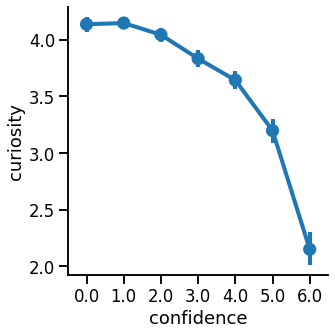

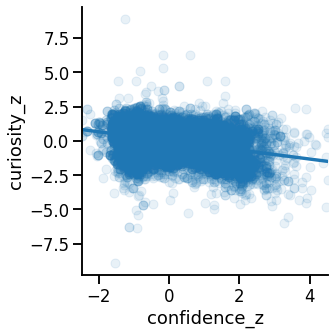

In [11]:
sns.catplot(x="confidence", y="curiosity",
            kind="point", data=dfo);

sns.lmplot(x="confidence_z", y="curiosity_z", scatter_kws={'alpha':0.1}, data=dfo);

r, p = stats.pearsonr(dfo.confidence_z, dfo.curiosity_z)
print('pearson r =', round(r,3), 'p-value = ', round(p,3))

Yes, a significant negative one. More confidence means less curiosity. Interestingly, other studies find intermediate confidence to be eliciting most curiosity. Is this moderated by accuracy of the guess?

Incorrect guess: pearson r = -0.227 p-value =  0.0
Correct guess: pearson r = -0.414 p-value =  0.0


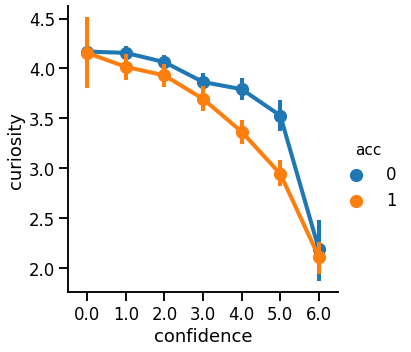

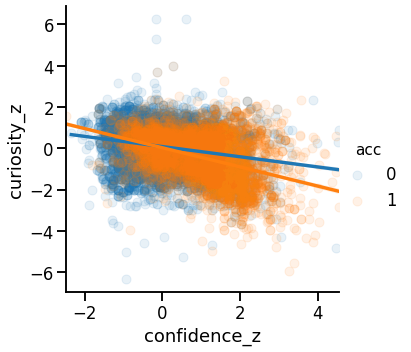

In [84]:
sns.catplot(x="confidence", y="curiosity",
            kind="point",hue='acc', data=dfo[dfo.madeguess==1]);

sns.lmplot(x="confidence_z", y="curiosity_z", hue='acc', scatter_kws={'alpha':0.1}, data=dfo[dfo.madeguess==1]);

r, p = stats.pearsonr(dfo[(dfo.acc==0) & (dfo.madeguess==1)].confidence_z, dfo[(dfo.acc==0) & (dfo.madeguess==1)].curiosity_z)
print('Incorrect guess: pearson r =', round(r,3), 'p-value = ', round(p,3))
r, p = stats.pearsonr(dfo[(dfo.acc==1) & (dfo.madeguess==1)].confidence_z, dfo[(dfo.acc==1) & (dfo.madeguess==1)].curiosity_z)
print('Correct guess: pearson r =', round(r,3), 'p-value = ', round(p,3))

Negative correlation seems to be (evidently) stronger for correct guesses. 

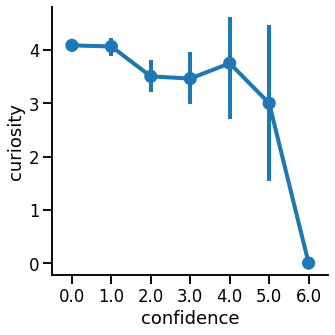

In [149]:
sns.catplot(x="confidence", y="curiosity",
            kind="point", data=dfo[dfo.madeguess==0]);


Note that datapoints represent very little data in this plot. Puzzlingly, some people (in 13% of the trials without guess) reported being have some confidence (confidence >1) about a guess they didn't make (laziness?).

In [228]:
len(dfo[(dfo.madeguess==0) & (dfo.confidence>0)])/ len(dfo[(dfo.madeguess==0)])

0.1269155206286837

## Does curiosity (pre-reveal) predict the strength of aha-experience (post-reveal)?

pearson r = 0.284 p-value =  0.0


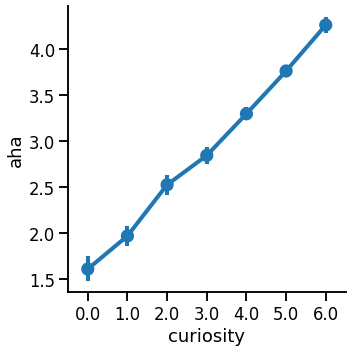

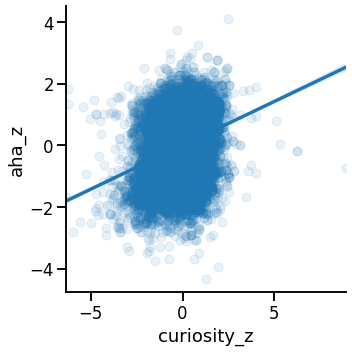

In [80]:
sns.catplot(x="curiosity", y="aha",
            kind="point", data=dfo);

sns.lmplot(x="curiosity_z", y="aha_z", scatter_kws={'alpha':0.1}, data=dfo);

r, p = stats.pearsonr(dfo.curiosity_z, dfo.aha_z)
print('pearson r =', round(r,3), 'p-value = ', round(p,3))

Yes, it does, significantly and positively, suggesting that people can to some extent predict their aha experience. Is it moderated by guess accuracy?

Incorrect guess: pearson r = 0.178 p-value =  0.0
Correct guess: pearson r = 0.353 p-value =  0.0


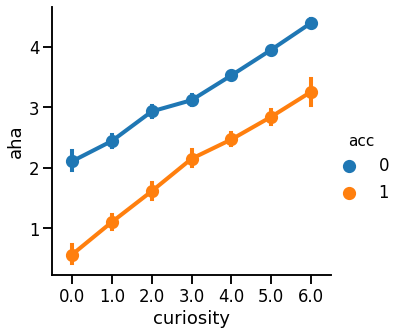

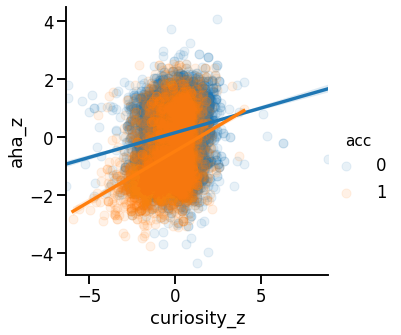

In [143]:
sns.catplot(x="curiosity", y="aha",
            kind="point",hue='acc', data=dfo);

sns.lmplot(x="curiosity_z", y="aha_z", hue='acc', scatter_kws={'alpha':0.1}, data=dfo);

r, p = stats.pearsonr(dfo[dfo.acc==0].curiosity_z, dfo[dfo.acc==0].aha_z)
print('Incorrect guess: pearson r =', round(r,3), 'p-value = ', round(p,3))
r, p = stats.pearsonr(dfo[dfo.acc==1].curiosity_z, dfo[dfo.acc==1].aha_z)
print('Correct guess: pearson r =', round(r,3), 'p-value = ', round(p,3))

Yes, if you're accurate aha increases even more with curiosity, but in general, incorrect guesses (and no guesses at all) seem to elicit a greater aha (blue line above orange), especially when curiosity is low.

## Does confidence predict aha experience?

pearson r = -0.25 p-value =  0.0


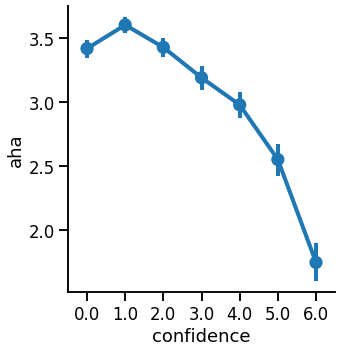

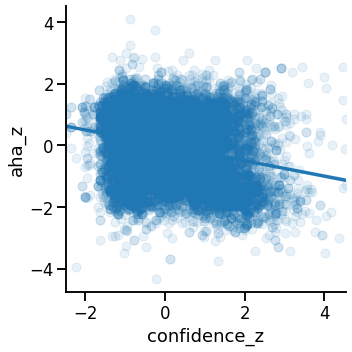

In [89]:
sns.catplot(x="confidence", y="aha",
            kind="point", data=dfo);

sns.lmplot(x="confidence_z", y="aha_z", scatter_kws={'alpha':0.1}, data=dfo);

r, p = stats.pearsonr(dfo.confidence_z, dfo.aha_z)
print('pearson r =', round(r,3), 'p-value = ', round(p,3))

Yes, it does, significantly and negatively: more confidence, less aha. Moderated by guess accuracy?

Incorrect guess: pearson r = -0.016 p-value =  0.0363
Correct guess: pearson r = -0.306 p-value =  0.0


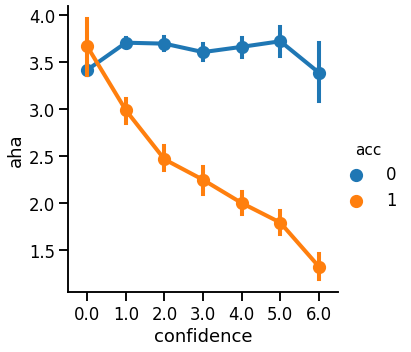

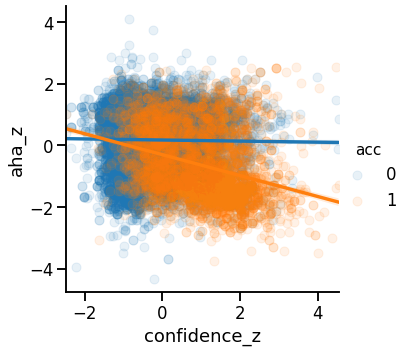

In [90]:
sns.catplot(x="confidence", y="aha",
            kind="point",hue='acc', data=dfo);

sns.lmplot(x="confidence_z", y="aha_z", hue='acc', scatter_kws={'alpha':0.1}, data=dfo);

r, p = stats.pearsonr(dfo[dfo.acc==0].confidence_z, dfo[dfo.acc==0].aha_z)
print('Incorrect guess: pearson r =', round(r,3), 'p-value = ', round(p,5))
r, p = stats.pearsonr(dfo[dfo.acc==1].confidence_z, dfo[dfo.acc==1].aha_z)
print('Correct guess: pearson r =', round(r,3), 'p-value = ', round(p,5))

Only for accurate guesses, aha really goes down with confidence, ie if you were highly confident of your guess and it turned out to be right, you have decreased aha (solution was too obvious, you didn't gain any new knowledge). If your guess was inaccurate, your confidence about it does not matter much in the aha experience, ie if you were highly confident of an inaccurate guess, there is no cost or benefit in aha. However, what if we limit the analysis to trials for which an actual guess was made?

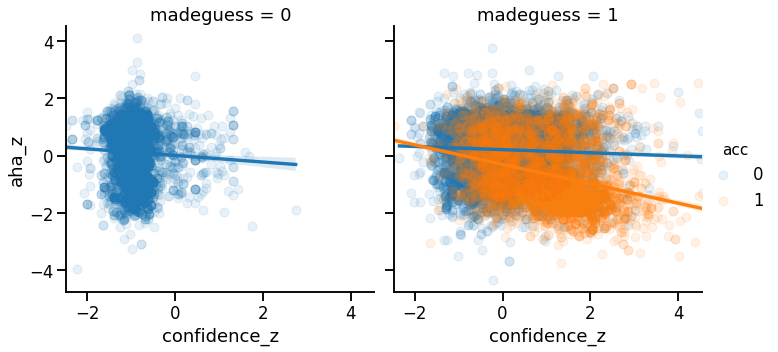

In [91]:
sns.lmplot(x="confidence_z", y="aha_z", hue='acc',col='madeguess', scatter_kws={'alpha':0.1}, data=dfo);

Very similar.

### Different way of plotting (splitting scores)

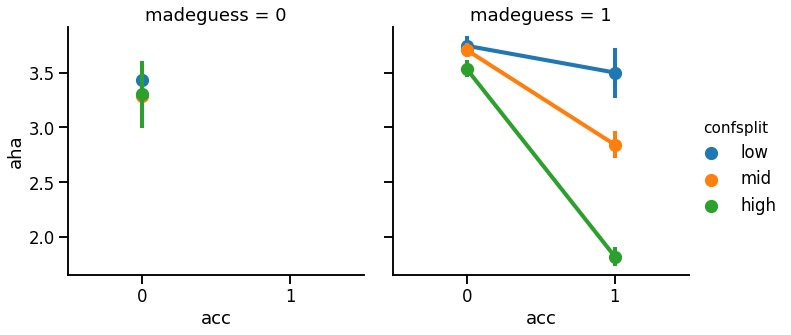

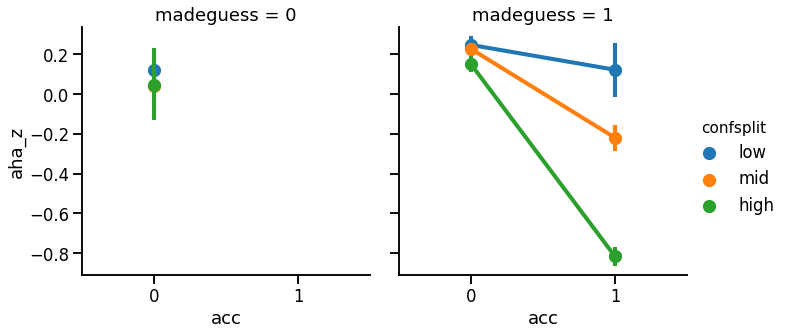

In [185]:
dfo['confsplit'] = pd.qcut(df.confidence_z, 3, labels=['low','mid','high'])

sns.catplot(x="acc", y="aha", hue="confsplit", kind="point", data=dfo[dfo.madeguess==1]);
sns.catplot(x="acc", y="aha_z", hue="confsplit", kind="point", data=dfo[dfo.madeguess==1]);


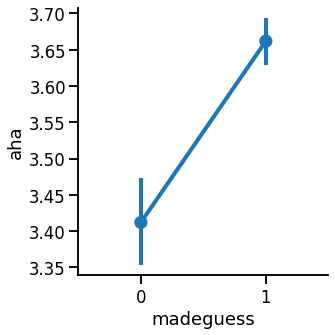

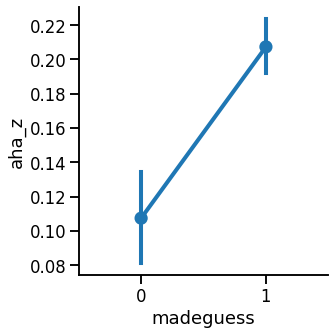

In [189]:

sns.catplot(x="madeguess", y="aha",  kind="point", dodge=.1, data=dfo[dfo.acc==0]);
sns.catplot(x="madeguess", y="aha_z", kind="point", dodge=.1, data=dfo[dfo.acc==0]);


Indeed, if we are only considering inaccurate responses, there's higher aha when you actually made a guess (see also Brod & Breitwieser 2019!). Cf. more engagement? + Expectation violation: stronger shift in probability distribution.

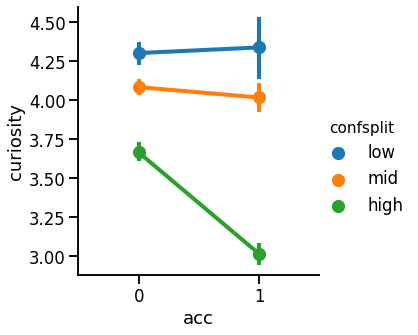

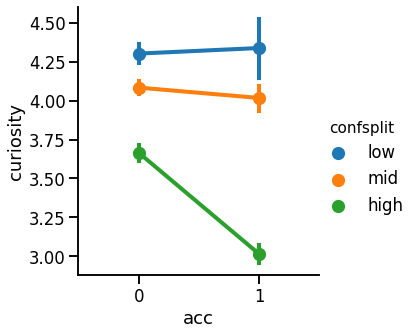

In [145]:
dfo['confsplit'] = pd.qcut(df.confidence_z, 3, labels=['low','mid','high'])

sns.catplot(x="acc", y="curiosity", hue="confsplit", kind="point", data=dfo[dfo.madeguess==1]);
sns.catplot(x="acc", y="curiosity_z", hue="confsplit", kind="point", data=dfo[dfo.madeguess==1]);


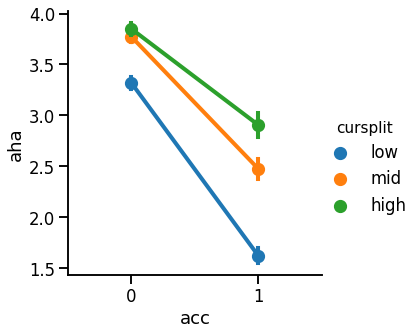

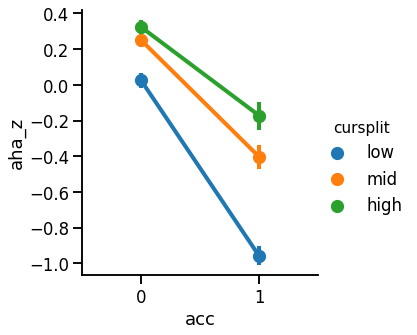

In [146]:
dfo['cursplit'] = pd.qcut(df.curiosity_z, 3, labels=['low','mid','high'])

sns.catplot(x="acc", y="aha", hue="cursplit", kind="point", data=dfo[dfo.madeguess==1]);
sns.catplot(x="acc", y="aha_z", hue="cursplit", kind="point", data=dfo[dfo.madeguess==1]);


## Are people just curious about the correctness of their guess?

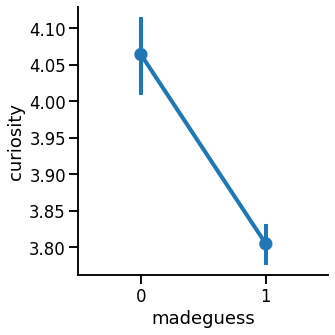

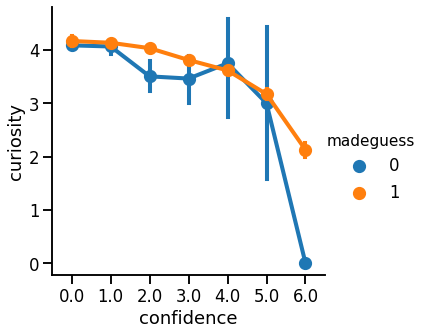

In [177]:
sns.catplot(x="madeguess", y="curiosity",
            kind="point", data=dfo);

sns.catplot(x="confidence", y="curiosity", hue='madeguess',
            kind="point", data=dfo);


Clearly they are also curious (even moreso) when they don't have a guess. However, puzzingly, there are people who were very confident and didn't make a guess.

## Does confidence predict accuracy (sanity check)?

pearson r = 0.5 p-value =  0.0


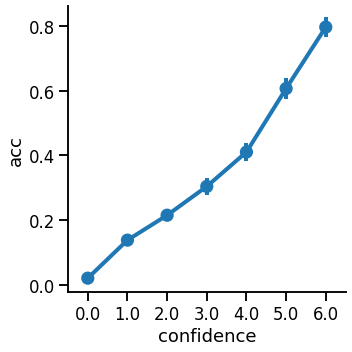

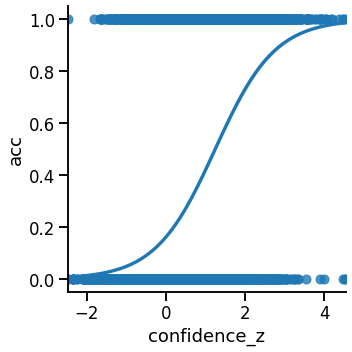

In [92]:
sns.catplot(x="confidence", y="acc",
            kind="point", data=dfo);
sns.lmplot(x="confidence_z", y="acc", data=dfo, logistic=True);

r, p = stats.pearsonr(dfo.confidence_z, dfo.acc)
print('pearson r =', round(r,3), 'p-value = ', round(p,3))

Yes, it does so strongly (starting from a participants' mean confidence), as expected. When people are confident that they’ve guessed correctly, their confidence is generally justified (i.e., they were right in thinking that they guessed correctly)

## Does curiosity link with accuracy?

pearson r = -0.219 p-value =  0.0


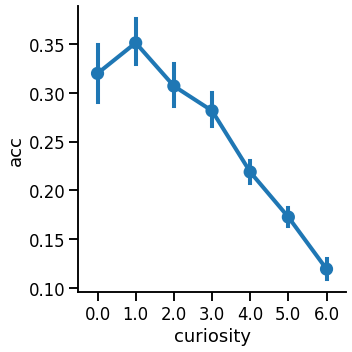

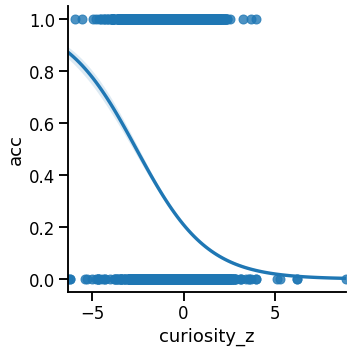

In [94]:
sns.catplot(x="curiosity", y="acc",
            kind="point", data=dfo);
sns.lmplot(x="curiosity_z", y="acc", data=dfo, logistic=True);

r, p = stats.pearsonr(dfo.curiosity_z, dfo.acc)
print('pearson r =', round(r,3), 'p-value = ', round(p,3))

Yes, as expected, lower accuracy means higher curiosity. People are more curious if their guess ends up being wrong (or if they didn’t guess at all).

## Does accuracy (pre-reveal) predict aha (post-reveal)?

pearson r = -0.331 p-value =  0.0


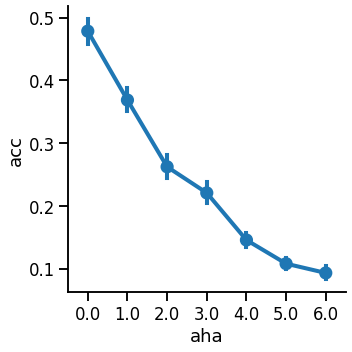

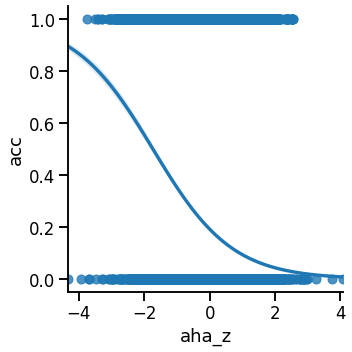

In [95]:
sns.catplot(x="aha", y="acc",
            kind="point", data=dfo);
sns.lmplot(x="aha_z", y="acc", data=dfo, logistic=True);

r, p = stats.pearsonr(dfo.aha_z, dfo.acc)
print('pearson r =', round(r,3), 'p-value = ', round(p,3))

Yes, as expected, lower accuracy is linked to higher aha. An incorrect guess is more likely to elicit a greater aha than a correct guess

## Does confidence predict familiarity?

pearson r = 0.184 p-value =  0.0


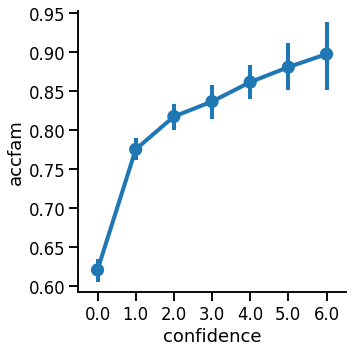

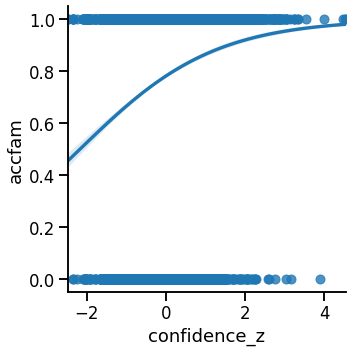

In [96]:
sns.catplot(x="confidence", y="accfam",
            kind="point", data=dfp);
sns.lmplot(x="confidence_z", y="accfam", data=dfp, logistic=True);

r, p = stats.pearsonr(dfp.confidence_z, dfp.accfam)
print('pearson r =', round(r,3), 'p-value = ', round(p,3))

Yes: more confidence, more accurate familiarity judgment.

## Does curiosity predict familiarity?

pearson r = 0.003 p-value =  0.663


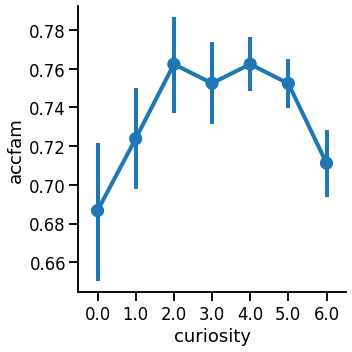

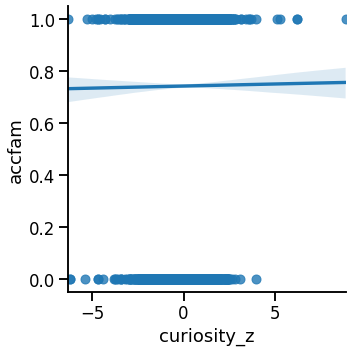

In [97]:
sns.catplot(x="curiosity", y="accfam",
            kind="point", data=dfp);
sns.lmplot(x="curiosity_z", y="accfam", data=dfp, logistic=True);

r, p = stats.pearsonr(dfp.curiosity_z, dfp.accfam)
print('pearson r =', round(r,3), 'p-value = ', round(p,3))

Not really, except maybe for the most extreme curiosity scores. Inverted u-shape?

## Does aha predict familiarity?

pearson r = 0.064 p-value =  0.0


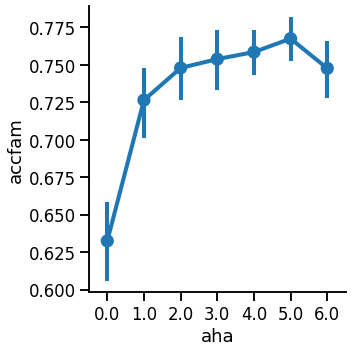

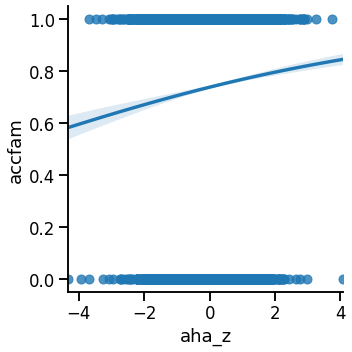

In [98]:
sns.catplot(x="aha", y="accfam",
            kind="point", data=dfp);
sns.lmplot(x="aha_z", y="accfam", data=dfp, logistic=True);

r, p = stats.pearsonr(dfp.aha_z, dfp.accfam)
print('pearson r =', round(r,3), 'p-value = ', round(p,3))

Mildly.

In [19]:
# model formulation
fml = "accfam ~ aha_z * curiosity_z * confidence_z"

# covariance structure
ex = sm.cov_struct.Exchangeable()
#link fu
fa = sm.families.Binomial(sm.families.links.logit)

model = sm.GEE.from_formula(fml, "subject", dfp.dropna(), cov_struct=ex, family=fa)
result = model.fit()
print(result.summary())
print(result.cov_struct.summary())

                               GEE Regression Results                              
Dep. Variable:                      accfam   No. Observations:                 8839
Model:                                 GEE   No. clusters:                      279
Method:                        Generalized   Min. cluster size:                   5
                      Estimating Equations   Max. cluster size:                  57
Family:                           Binomial   Mean cluster size:                31.7
Dependence structure:         Exchangeable   Num. iterations:                     8
Date:                     Thu, 07 May 2020   Scale:                           1.000
Covariance type:                    robust   Time:                         20:02:17
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          1.9960     

## Does aha predict recognition memory?

pearson r = 0.123 p-value =  0.0


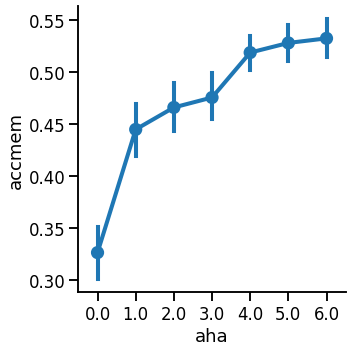

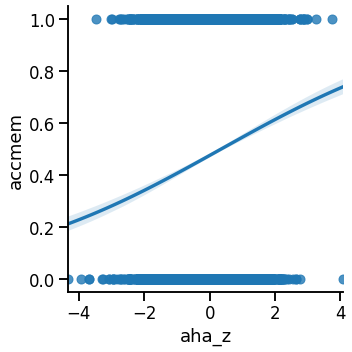

In [100]:

sns.catplot(x="aha", y="accmem",
            kind="point", data=dfp);
sns.lmplot(x="aha_z", y="accmem", data=dfp, logistic=True);

r, p = stats.pearsonr(dfp.aha_z, dfp.accmem)
print('pearson r =', round(r,3), 'p-value = ', round(p,3))

Yes: more aha, better recognition memory. Note that this is acc==0 data only, acc does change the relation:

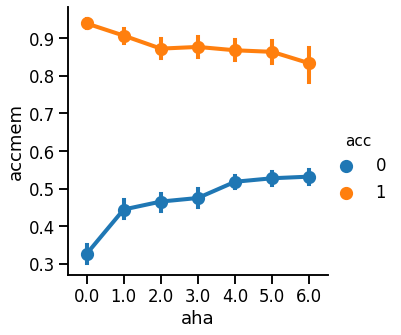

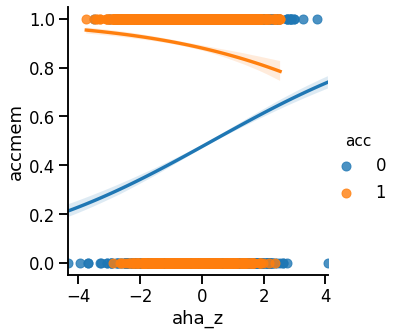

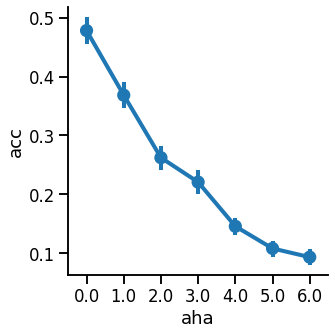

In [191]:

sns.catplot(x="aha", y="accmem",hue="acc",
            kind="point", data=dfo);
sns.lmplot(x="aha_z", y="accmem", hue="acc", data=dfo, logistic=True);
sns.catplot(x="aha", y="acc", kind="point", data=dfo);

- If I was correct the first time, and I had no aha, I'm most accurate the second time (memory): this is probably because the content is obvious irrespective of solution. I'm above 90%, while with higher aha memory seems to drop slightly. 
- If I wasn't correct and had no aha my recognition memory is worst of all (likely for mooneys that were difficult to recognize, even after seeing the solution) but it increases to above 50% with stronger aha (for comparison, base level (first phase) accuracy is at +/-22 percent).
- This suggests that the greater the ‘aha experience’, the more strongly they encoded the image. The ones that elicit a strong aha may the “best” in terms of information gain, giving us the largest perceptual shift.

In [20]:
dfo.acc.mean()

0.22343189964157706

In [21]:
# model formulation
fml = "accmem ~ aha_z * acc"

# covariance structure
ex = sm.cov_struct.Exchangeable()
#link fu
fa = sm.families.Binomial(sm.families.links.logit)

model = sm.GEE.from_formula(fml, "subject", dfo, cov_struct=ex, family=fa)
result = model.fit()
print(result.summary())
print(result.cov_struct.summary())


                               GEE Regression Results                              
Dep. Variable:                      accmem   No. Observations:                22320
Model:                                 GEE   No. clusters:                      279
Method:                        Generalized   Min. cluster size:                  80
                      Estimating Equations   Max. cluster size:                  80
Family:                           Binomial   Mean cluster size:                80.0
Dependence structure:         Exchangeable   Num. iterations:                     8
Date:                     Thu, 07 May 2020   Scale:                           1.000
Covariance type:                    robust   Time:                         20:02:34
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0612      0.033     -1.844      0.065      -0.126       0.004
aha_z  

In [22]:
# model formulation
fml = "accmem ~ aha_z * curiosity_z * confidence_z * acc"

# covariance structure
ex = sm.cov_struct.Exchangeable()
#link fu
fa = sm.families.Binomial(sm.families.links.logit)

model = sm.GEE.from_formula(fml, "subject", dfo, cov_struct=ex, family=fa)
result = model.fit()
print(result.summary())
print(result.cov_struct.summary())


                               GEE Regression Results                              
Dep. Variable:                      accmem   No. Observations:                22320
Model:                                 GEE   No. clusters:                      279
Method:                        Generalized   Min. cluster size:                  80
                      Estimating Equations   Max. cluster size:                  80
Family:                           Binomial   Mean cluster size:                80.0
Dependence structure:         Exchangeable   Num. iterations:                    10
Date:                     Thu, 07 May 2020   Scale:                           1.000
Covariance type:                    robust   Time:                         20:02:47
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                             

A model with every pre-reveal measure predicting recognition memory shows an effect of aha, of confidence, of acc, and an interaction between aha*acc. Notice that curiosity is not significant, but when aha is dropped from the model, it becomes strongly significant.

### Import R interface, libraries

In [293]:
import rpy2.rinterface
%reload_ext rpy2.ipython
import warnings
warnings.filterwarnings('ignore')

In [103]:
%%R 

library(lme4)
library(tidyverse)
library(ggplot2)
library(lmerTest)

In [97]:
dfo.to_csv('dfo.csv')

In [111]:
%%R 

dfo <- suppressMessages(read_csv('dfo.csv'))
dfo$subject <- as.factor(dfo$subject)

#general linear mixed model with DV = correct, IV within = dsd
glmer_acc<- glmer(accmem ~ aha_z * acc + curiosity_z * acc + aha_z * curiosity_z + aha_z * confidence_z + curiosity_z * confidence_z + confidence_z * acc +(1|currentStim), family = binomial, data = dfo)
summary(glmer_acc)

R[write to console]: Warning:
R[write to console]:  160 parsing failures.
 row     col expected actual      file
2801 subject a double     CA 'dfo.csv'
2802 subject a double     CA 'dfo.csv'
2803 subject a double     CA 'dfo.csv'
2804 subject a double     CA 'dfo.csv'
2805 subject a double     CA 'dfo.csv'
.... ....... ........ ...... .........
See problems(...) for more details.




Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: accmem ~ aha_z * acc + curiosity_z * acc + aha_z * curiosity_z +  
    aha_z * confidence_z + curiosity_z * confidence_z + confidence_z *  
    acc + (1 | currentStim)
   Data: dfo

     AIC      BIC   logLik deviance df.resid 
 23526.2  23621.7 -11751.1  23502.2    21188 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-12.0503  -0.7528   0.2575   0.7454   4.0673 

Random effects:
 Groups      Name        Variance Std.Dev.
 currentStim (Intercept) 0.7777   0.8819  
Number of obs: 21200, groups:  currentStim, 203

Fixed effects:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)               0.01762    0.06494   0.271   0.7861    
aha_z                     0.26184    0.02045  12.805  < 2e-16 ***
acc                       1.68633    0.06403  26.335  < 2e-16 ***
curiosity_z               0.04066    0.01961   2.07

## Does curiosity (pre-reveal) predict recognition memory?

pearson r = 0.043 p-value =  0.0


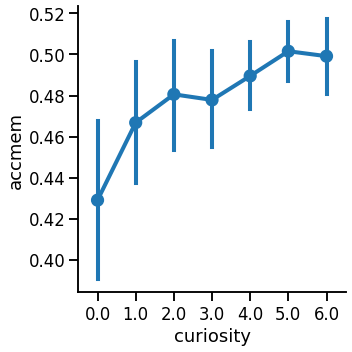

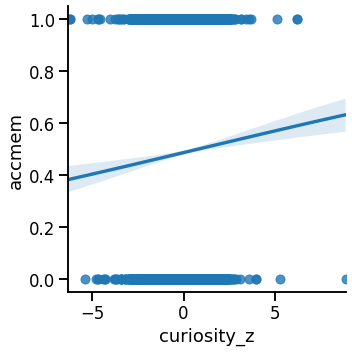

In [125]:
sns.catplot(x="curiosity", y="accmem",
            kind="point", data=dfp);
sns.lmplot(x="curiosity_z", y="accmem", data=dfp, logistic=True);

r, p = stats.pearsonr(dfp.curiosity_z, dfp.accmem)
print('pearson r =', round(r,3), 'p-value = ', round(p,3))

Barely, but significantly. Unexpectedly low, given prior findings on relation between curiosity and memory. Maybe those findings (and ours) are mediated by aha, as the more important factor in memory.

## Does aha mediate the effect of curiosity on recognition memory?

ACME = average causal mediation effect; ADE = average direct effect. https://www.statsmodels.org/stable/generated/statsmodels.stats.mediation.Mediation.html
https://m-clark.github.io/posts/2019-03-12-mediation-models/#python

In [72]:
import statsmodels.genmod.families.links as links
from statsmodels.stats.mediation import Mediation
probit = links.probit
outcome_model = sm.GLM.from_formula("accmem ~ curiosity + aha",
                                    dfp, family=sm.families.Binomial(link=probit()))
mediator_model = sm.OLS.from_formula("aha ~ curiosity", dfp)
med = Mediation(outcome_model, mediator_model, "curiosity", "aha").fit()
med.summary()

Estimate  Lower CI bound  Upper CI bound  P-value
ACME (control)            0.010864        0.008968        0.012895    0.000
ACME (treated)            0.010858        0.008961        0.012883    0.000
ADE (control)            -0.002653       -0.007403        0.002313    0.272
ADE (treated)            -0.002659       -0.007411        0.002323    0.272
Total effect              0.008205        0.003775        0.013212    0.004
Prop. mediated (control)  1.331159        0.815363        2.909103    0.004
Prop. mediated (treated)  1.330282        0.816088        2.906118    0.004
ACME (average)            0.010861        0.008965        0.012893    0.000
ADE (average)            -0.002656       -0.007407        0.002318    0.272
Prop. mediated (average)  1.330721        0.815726        2.907610    0.004

Ignore the separate control/treated rows, they are the same here, because there is no categorical 'treatment' (for which effects would be estimated separately)

The important thing to note is that the indirect effect is significant, while the direct effect isn't, suggesting that most of curiosity's significant total effect on recognition memory is mediated by subsequent aha, rather than being a direct influence.

## Does confidence predict recognition memory?

pearson r = 0.054 p-value =  0.0


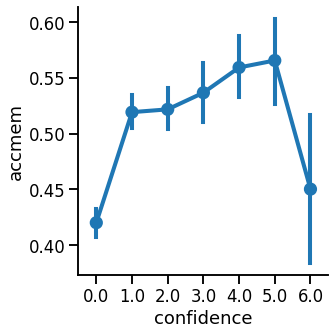

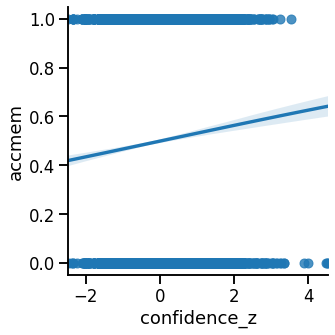

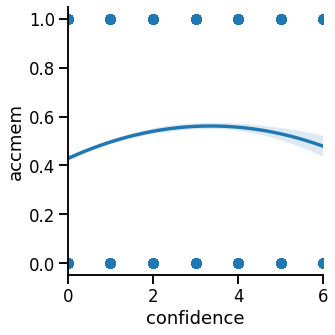

In [62]:
sns.catplot(x="confidence", y="accmem",
            kind="point", data=dfp);
sns.lmplot(x="confidence_z", y="accmem", data=dfp, logistic=True);

sns.lmplot(x="confidence", y="accmem", data=dfp,
           order=2, scatter_kws={"s": 80});

r, p = stats.pearsonr(dfp.confidence_z, dfp.accmem)
print('pearson r =', round(r,3), 'p-value = ', round(p,3))

No, but note a possible effect of the extremes on the confidence scale, suggestive of an inverted u-shape? if so, medium confidence at first guess related to higher accuracy on second guess 

### Does gain PE predict memory?

GainPE = aha minus curiosity. Assuming aha is a kind of relief/reward, this would be actual reward minus expected reward (of information, ie curiosity). One study with trivia questions finds it predicts memory.

pearson r = 0.071 p-value =  0.0


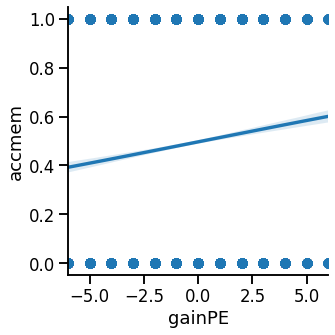

In [35]:
sns.lmplot(x="gainPE", y="accmem", data=dfp, logistic=True);
r, p = stats.pearsonr(dfp.gainPE, dfp.accmem)
print('pearson r =', round(r,3), 'p-value = ', round(p,3))

In [67]:
# model formulation
fml = "accmem ~ aha * acc * pow(confidence,2)"

# covariance structure
ex = sm.cov_struct.Exchangeable()
#link fu
fa = sm.families.Binomial(sm.families.links.logit)

model = sm.GEE.from_formula(fml, "subject", dfo, cov_struct=ex, family=fa)
result = model.fit()
print(result.summary())
print(result.cov_struct.summary())

                               GEE Regression Results                              
Dep. Variable:                      accmem   No. Observations:                22320
Model:                                 GEE   No. clusters:                      279
Method:                        Generalized   Min. cluster size:                  80
                      Estimating Equations   Max. cluster size:                  80
Family:                           Binomial   Mean cluster size:                80.0
Dependence structure:         Exchangeable   Num. iterations:                     9
Date:                     Thu, 07 May 2020   Scale:                           1.000
Covariance type:                    robust   Time:                         20:33:31
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -0.5089      0.062     -

In [68]:
# model formulation
fml = "accmem ~ gainPE * aha * acc * confidence"

# covariance structure
ex = sm.cov_struct.Exchangeable()
#link fu
fa = sm.families.Binomial(sm.families.links.logit)

model = sm.GEE.from_formula(fml, "subject", dfo, cov_struct=ex, family=fa)
result = model.fit()
print(result.summary())
print(result.cov_struct.summary())

                               GEE Regression Results                              
Dep. Variable:                      accmem   No. Observations:                22320
Model:                                 GEE   No. clusters:                      279
Method:                        Generalized   Min. cluster size:                  80
                      Estimating Equations   Max. cluster size:                  80
Family:                           Binomial   Mean cluster size:                80.0
Dependence structure:         Exchangeable   Num. iterations:                    10
Date:                     Thu, 07 May 2020   Scale:                           1.000
Covariance type:                    robust   Time:                         20:34:19
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -0.5109      0.090     -5.7

Not when taking aha into consideration.

## Is the difference in aha compared to the rolling average aha predictive of recognition memory?

pearson r = 0.123 p-value =  0.0


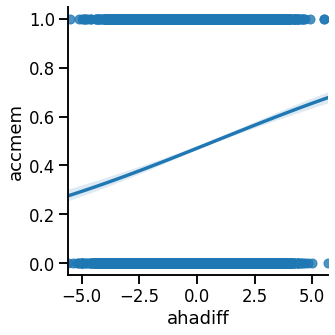

In [69]:
sns.lmplot(x="ahadiff", y="accmem", data=dfp, logistic=True);
dff = dfp[['ahadiff', 'accmem']].dropna()
r, p = stats.pearsonr(dff.ahadiff, dff.accmem)
print('pearson r =', round(r,3), 'p-value = ', round(p,3))

In [70]:
# model formulation
fml = "accmem ~ aha * confidence * curiosity + ahadiff"

# covariance structure
ex = sm.cov_struct.Exchangeable()
#link fu
fa = sm.families.Binomial(sm.families.links.logit)

model = sm.GEE.from_formula(fml, "subject", dfp, cov_struct=ex, family=fa)
result = model.fit()
print(result.summary())
print(result.cov_struct.summary())

                               GEE Regression Results                              
Dep. Variable:                      accmem   No. Observations:                15214
Model:                                 GEE   No. clusters:                      279
Method:                        Generalized   Min. cluster size:                  36
                      Estimating Equations   Max. cluster size:                  68
Family:                           Binomial   Mean cluster size:                54.5
Dependence structure:         Exchangeable   Num. iterations:                     7
Date:                     Thu, 07 May 2020   Scale:                           1.000
Covariance type:                    robust   Time:                         20:38:06
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -0.2653      0.150     -1.767 

Interesting to see that when controlling for aha, confidence and curiosity, only ahadiff is significant with regard to recognition memory. If aha is a measure of surprise or reward/relief, then the amount of surprise/reward/relief compared to the local baseline (average or expected surprise/reward/relief) influences memory .  

In [71]:
# model formulation
fml = "curiosity ~ aha * confidence + prevrollingcur"

# covariance structure
ex = sm.cov_struct.Exchangeable()
#link fu
fa = sm.families.Gaussian()

model = sm.GEE.from_formula(fml, "subject", dfp, cov_struct=ex, family=fa)
result = model.fit()
print(result.summary())
print(result.cov_struct.summary())

                               GEE Regression Results                              
Dep. Variable:                   curiosity   No. Observations:                15214
Model:                                 GEE   No. clusters:                      279
Method:                        Generalized   Min. cluster size:                  36
                      Estimating Equations   Max. cluster size:                  68
Family:                           Gaussian   Mean cluster size:                54.5
Dependence structure:         Exchangeable   Num. iterations:                    24
Date:                     Thu, 07 May 2020   Scale:                           2.240
Covariance type:                    robust   Time:                         20:38:21
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.3813      0.149     22.651      0.000       3.089       3

Curiosity does not seem to depend on recent average curiosity (or aha or confidence).

## Aha, confidence, curiosity rating distributions

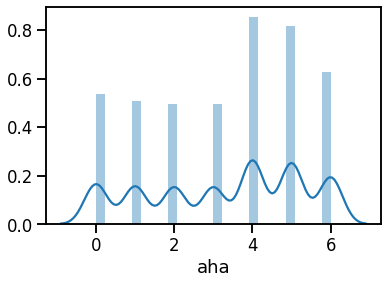

In [19]:
sns.distplot(df.aha.dropna())

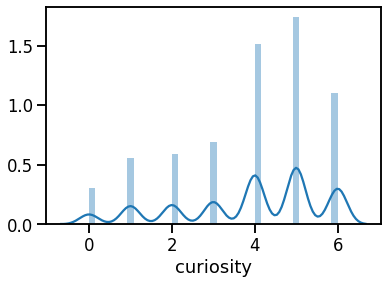

In [20]:
sns.distplot(df.curiosity.dropna())

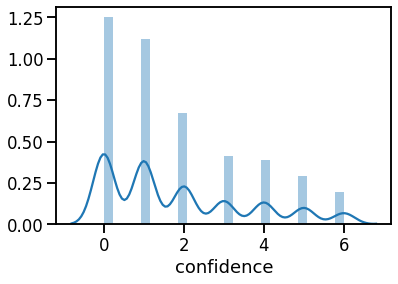

In [21]:
sns.distplot(df.confidence.dropna())

# Per subject analysis 

In [154]:

dfsubj = df[(df.old==1)].groupby(['subject']).agg(
    nbofobs=pd.NamedAgg(column='accfam', aggfunc='count'),
    countguess=pd.NamedAgg(column='guess', aggfunc='count'),
    countmem=pd.NamedAgg(column='guessmem', aggfunc='count'),
    accfamstd=pd.NamedAgg(column='accfam', aggfunc='std'),
    accstd=pd.NamedAgg(column='acc', aggfunc='std'),
    accmemstd=pd.NamedAgg(column='accmem', aggfunc='std'),
    confstd=pd.NamedAgg(column='confidence', aggfunc='std'),
    curstd=pd.NamedAgg(column='curiosity', aggfunc='std'),
    ahastd=pd.NamedAgg(column='aha', aggfunc='std')).reset_index()

dfsubj = dfsubj.merge(df[df.old==1].groupby('subject').mean().reset_index(), on='subject')

In [612]:
dfsubj.head()

subject  nbofobs  countguess  countmem  accfamstd    accstd  accmemstd  \
0   00000       80          70        76   0.243589  0.428236   0.382364   
1   29689       80          71        72   0.346547  0.442769   0.461149   
2   33928       80          71        66   0.461149  0.332805   0.492989   
3   34003       80          63        60   0.455452  0.359324   0.499208   
4   34174       80          69        65   0.471330  0.435745   0.501737   

    confstd    curstd    ahastd  ...   NCS   AQ28  socskills  routine  \
0  1.583938  0.841093  1.229837  ...  34.0   82.0       23.0     12.0   
1  1.987142  0.584477  2.048116  ...  55.0   70.0       21.0     10.0   
2  0.758809  1.297515  1.509254  ...  39.0   89.0       24.0     14.0   
3  1.483240  1.218008  1.590319  ...  44.0  106.0       32.0     18.0   
4  2.098673  2.129918  2.439651  ...  32.0   77.0       19.0     10.0   

   switching  imagination  numbpatt     acc  accmem  madeguess  
0       14.0         23.0      10.0  0.2375  0.8250     0.8750  
1       14.0         13.0      12.0  0.2625  0.7000     0.8875  
2       19.0         27.0       5.0  0.1250  0.4000     0.8875  
3       19.0         20.0      17.0  0.1500  0.4375     0.7875  
4       18.0         30.0       0.0  0.2500  0.5375     0.8625  

[5 rows x 120 columns]

In [616]:
dfsubj[dfsubj.datajoin==1].to_csv('dfbysubj.csv')

In [155]:
dfsubj['gain']= dfsubj.accmem - dfsubj.acc

In [ ]:
sns.catplot(x="sex", y="survived", hue="class", kind="point", data=titanic);


## Does a person's avg curiosity relate to his/her strength of aha or confidence?

pearson r = 0.589 p-value =  0.0


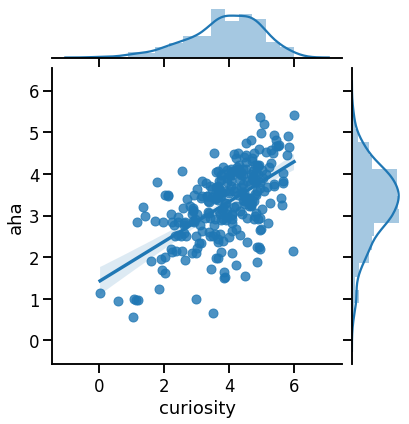

In [131]:
sns.jointplot(x="curiosity", y="aha", data=dfsubj, kind="reg");

r, p = stats.pearsonr(dfsubj.curiosity, dfsubj.aha)
print('pearson r =', round(r,3), 'p-value = ', round(p,3))

pearson r = -0.014 p-value =  0.818


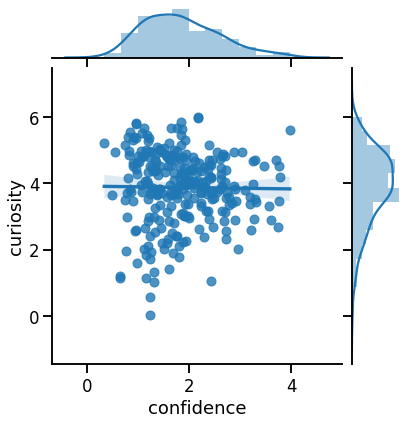

In [132]:
sns.jointplot(x="confidence", y="curiosity", data=dfsubj, kind="reg");
r, p = stats.pearsonr(dfsubj.confidence, dfsubj.curiosity)
print('pearson r =', round(r,3), 'p-value = ', round(p,3))

pearson r = 0.131 p-value =  0.033


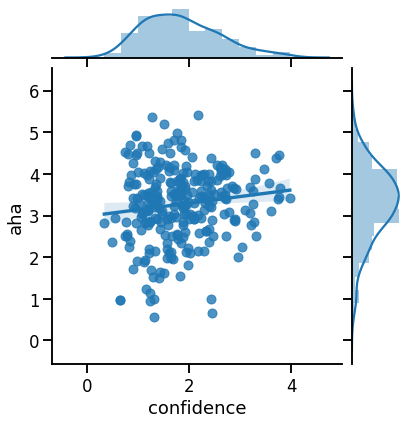

In [133]:
sns.jointplot(x="confidence", y="aha", data=dfsubj, kind="reg");
r, p = stats.pearsonr(dfsubj.confidence, dfsubj.aha)
print('pearson r =', round(r,3), 'p-value = ', round(p,3))

#### Conclusions

- Avg curiosity is positively related to a person's avg aha strength.
- No relation between confidence and curiosity on the person level
- A small, barely significant correlation between confidence and aha on person level.

## Person-level correlations with recognition memory

In [194]:
dfsubj = df[df.old==1].groupby(['subject', 'acc']).mean().reset_index()

confidence pearson r = 0.185 p-value =  0.003
aha pearson r = 0.131 p-value =  0.033


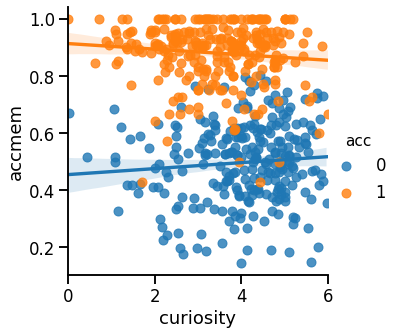

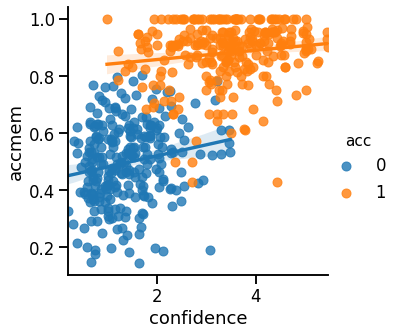

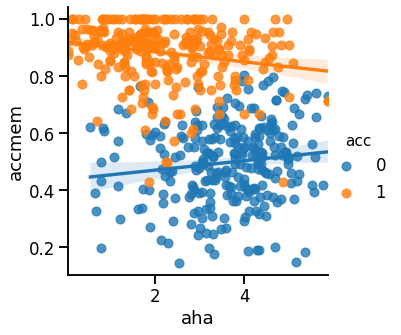

In [198]:
sns.lmplot(x="curiosity", y="accmem", hue="acc", data=dfsubj);
sns.lmplot(x="confidence", y="accmem", hue="acc", data=dfsubj);
sns.lmplot(x="aha", y="accmem",hue="acc", data=dfsubj);

r, p = stats.pearsonr(dfsubj[dfsubj.acc==0].confidence, dfsubj[dfsubj.acc==0].accmem)
print('confidence pearson r =', round(r,3), 'p-value = ', round(p,3))
r, p = stats.pearsonr(dfsubj[dfsubj.acc==0].aha, dfsubj[dfsubj.acc==0].accmem)
print('aha pearson r =', round(r,3), 'p-value = ', round(p,3))

Minor correlations. Probably not very meaningful. It suggests that the effect of aha on memory largely takes place within person.

## Does individual learning gain relate to avg aha?

pearson r = 0.029 p-value =  0.638


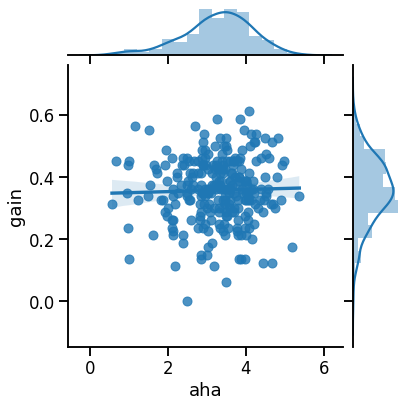

In [160]:
sns.jointplot(x="aha", y="gain", data=dfsubj, kind="reg");
r, p = stats.pearsonr(dfsubj.aha, dfsubj.gain)
print('pearson r =', round(r,3), 'p-value = ', round(p,3))

No, it seems all aha effects on learning take place *within* person.

## Does a person's avg curiosity relate to general curiosity measures (+ other traits from questionnaires)?

In [136]:
dfsubj = df[(df.old==1) & (df.acc==0)].groupby(['subject']).mean().reset_index()

fiveDCR pearson r = 0.128 p-value =  0.036
joyexp pearson r = 0.061 p-value =  0.317
deprsens pearson r = 0.1 p-value =  0.103
stresstol pearson r = -0.009 p-value =  0.888
ovsoccur pearson r = 0.188 p-value =  0.002
cosoccur pearson r = 0.14 p-value =  0.022
thrillseek pearson r = -0.023 p-value =  0.711
perccur pearson r = 0.142 p-value =  0.02
NCS pearson r = 0.006 p-value =  0.927
AQ28 pearson r = -0.023 p-value =  0.706
socskills pearson r = 0.005 p-value =  0.929
routine pearson r = -0.081 p-value =  0.189
switching pearson r = -0.075 p-value =  0.224
imagination pearson r = -0.028 p-value =  0.645
numbpatt pearson r = 0.082 p-value =  0.18


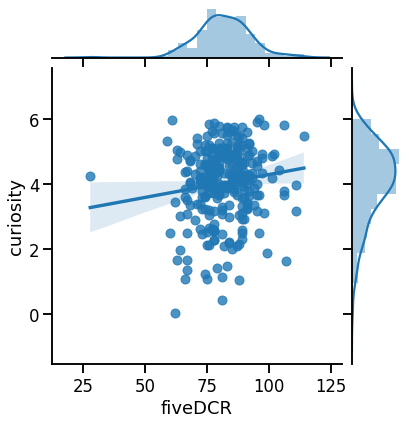

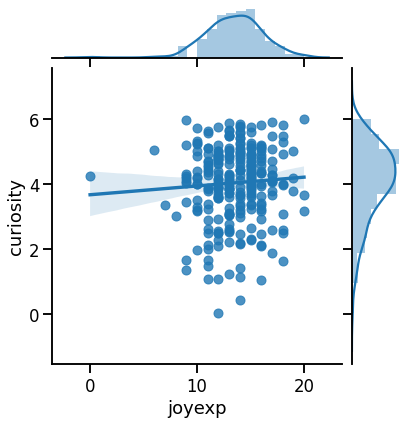

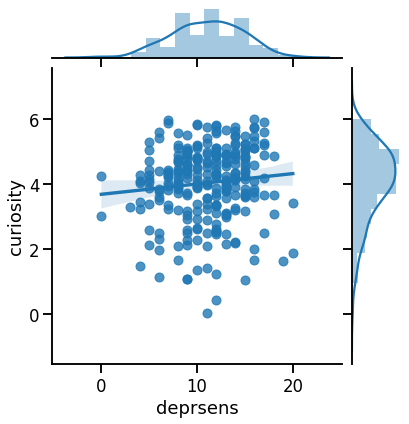

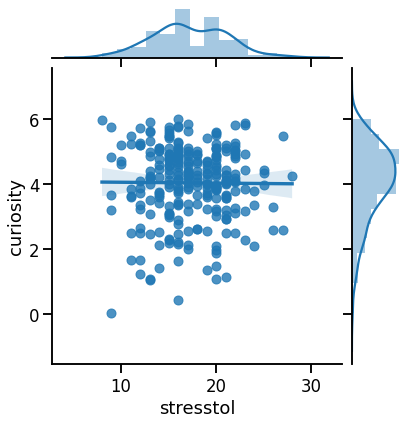

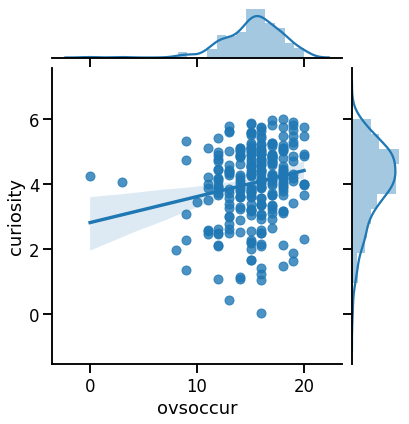

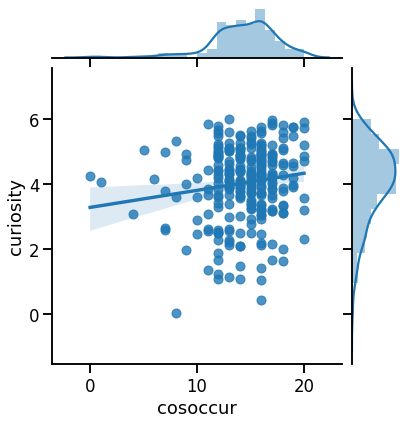

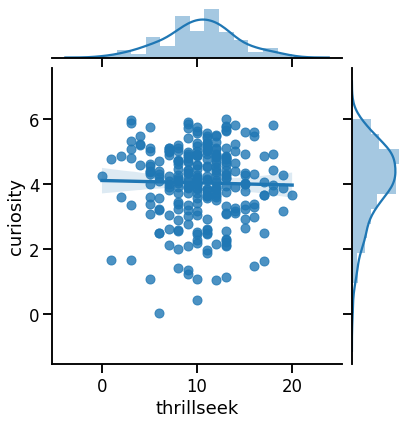

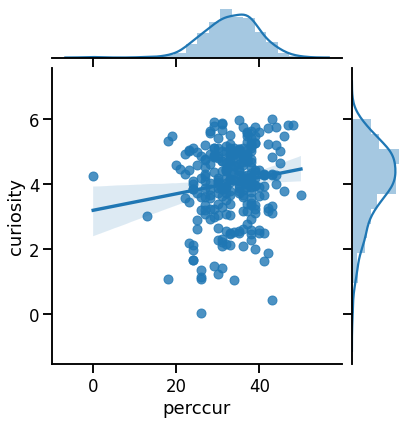

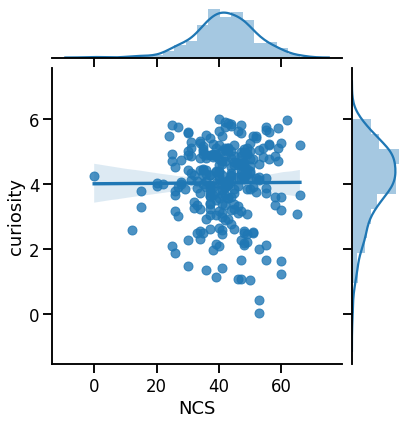

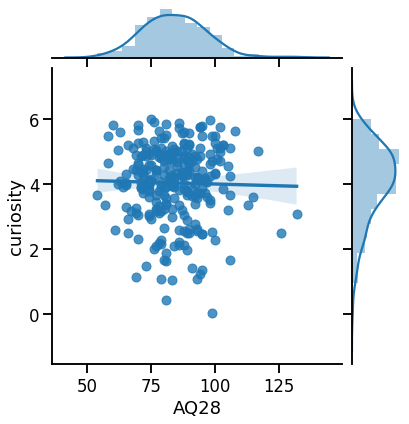

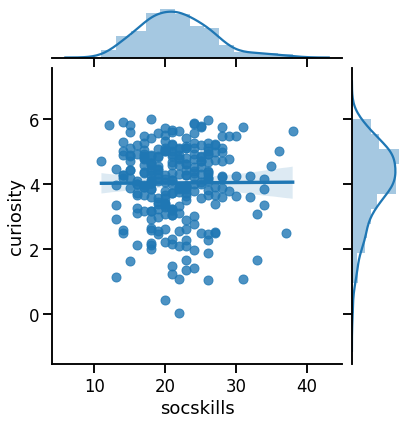

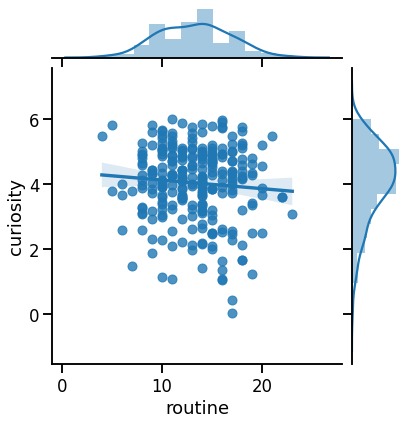

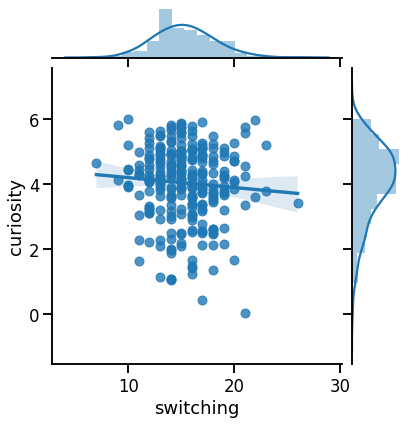

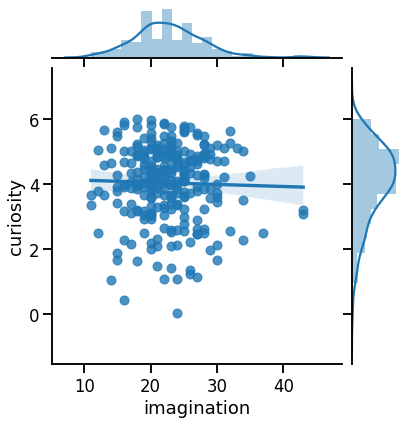

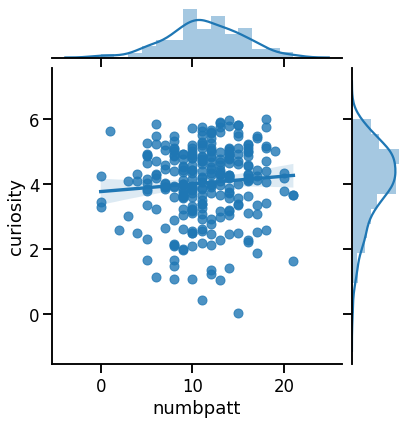

In [137]:
for quest in ['fiveDCR', 'joyexp', 'deprsens','stresstol','ovsoccur','cosoccur', 'thrillseek', 'perccur', 
              'NCS', 'AQ28', 'socskills','routine','switching', 'imagination', 'numbpatt']:
    
    r, p = stats.pearsonr(dfsubj.curiosity, dfsubj[quest])
    sns.jointplot(x=quest, y="curiosity", data=dfsubj, kind="reg");
    print(quest,'pearson r =', round(r,3), 'p-value = ', round(p,3))


#### Conclusions:

- Avg state curiosity in our task correlates positively, significantly with a conventional trait curiosity questionnaire (the 5-dimensional curiosity scale Revised; 5DCR)
- This correlation seems mostly caused by the correlation with the (overt) social curiosity subscale(s). However, correlations are rather small (meaning that our state curiosity is not well-captured by the trait curiosity measures).
- The 5DCR does not include a sensory curiosity subscale. Hence, we added one (Perceptual curiosity scale), and, as expected trait perceptual curiosity significantly correlates with avg state curiosity in our task.
- Notably, the autism questionnaire nor the need for closure scale correlates with avg state curiosity. Interestingly (see matrix below), AQ28 is strongly negatively related to trait curiosity (5DCR), suggesting either that trait curiosity (but not state curiosity as measured in our task) is lower in people with more ASD-like traits, and/or that trait curiosity as measured by the 5DCR is too much focused on social curiosity (however note that trait perceptual curiosity is also somewhat negatively related with AQ28).

## Does a person's learning gain relate to general curiosity measures (+ other traits from questionnaires)?

fiveDCR pearson r = 0.055 p-value =  0.375
joyexp pearson r = 0.062 p-value =  0.313
deprsens pearson r = -0.009 p-value =  0.882
stresstol pearson r = 0.059 p-value =  0.342
ovsoccur pearson r = 0.019 p-value =  0.764
cosoccur pearson r = -0.012 p-value =  0.849
thrillseek pearson r = 0.055 p-value =  0.37
perccur pearson r = 0.136 p-value =  0.027
NCS pearson r = -0.048 p-value =  0.435
AQ28 pearson r = -0.073 p-value =  0.233
socskills pearson r = 0.012 p-value =  0.852
routine pearson r = -0.04 p-value =  0.521
switching pearson r = -0.072 p-value =  0.244
imagination pearson r = -0.188 p-value =  0.002
numbpatt pearson r = 0.086 p-value =  0.161


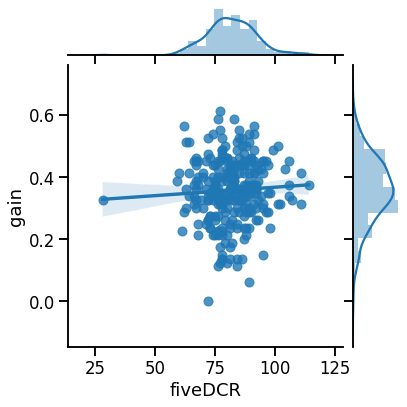

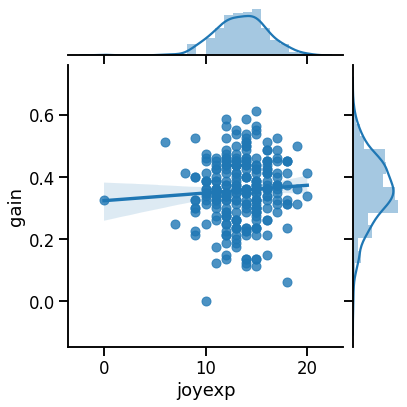

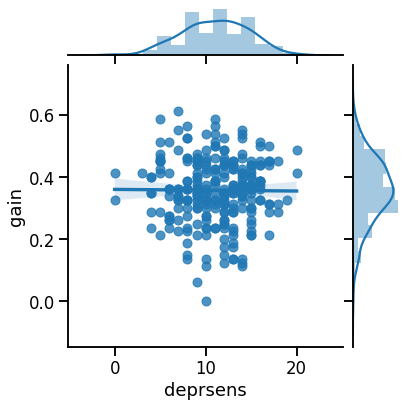

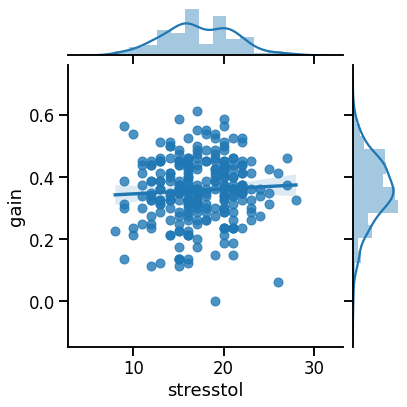

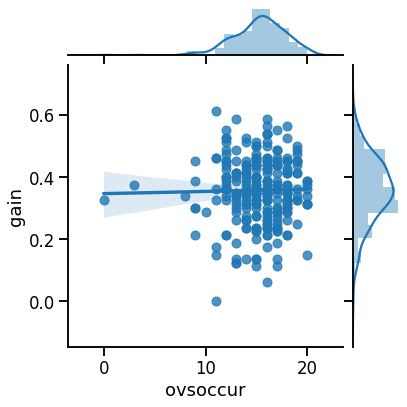

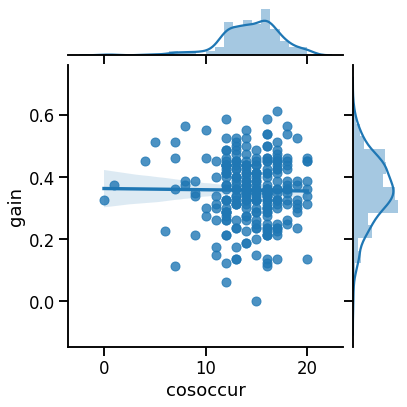

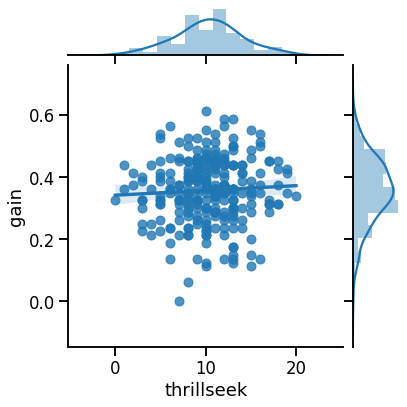

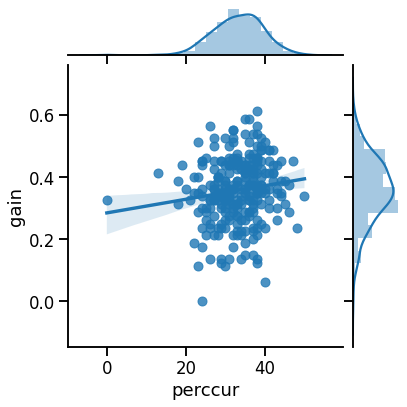

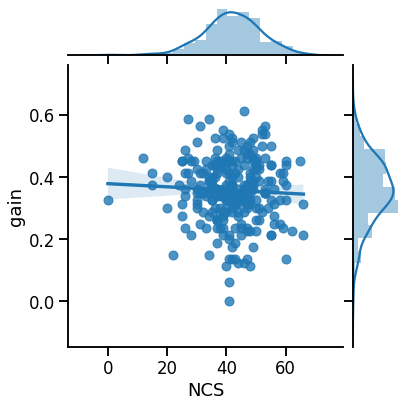

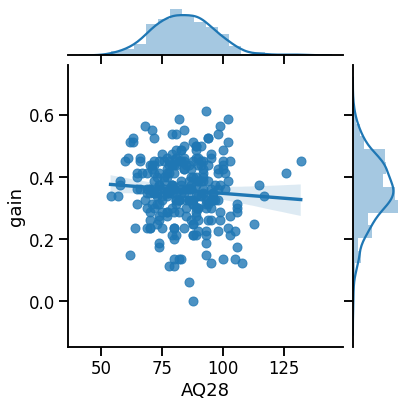

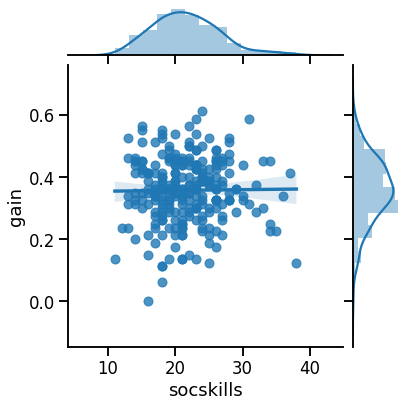

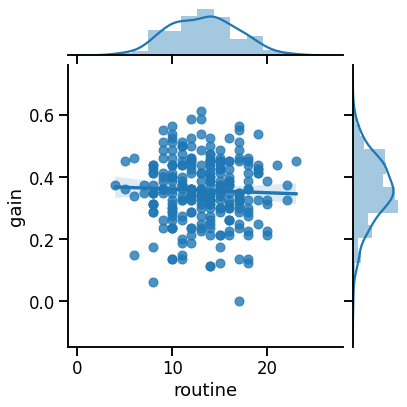

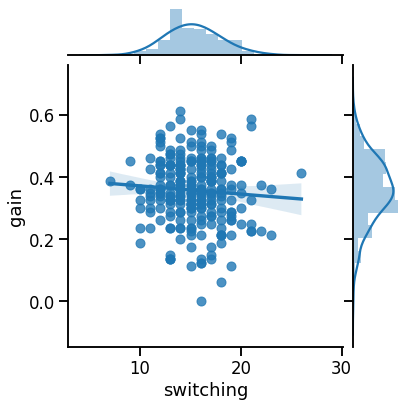

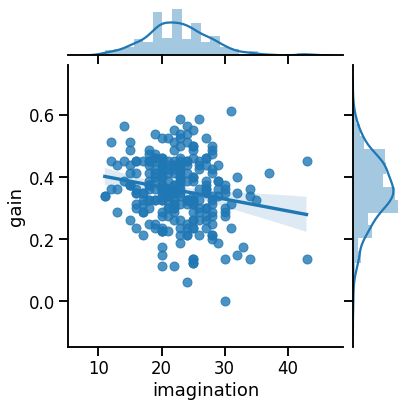

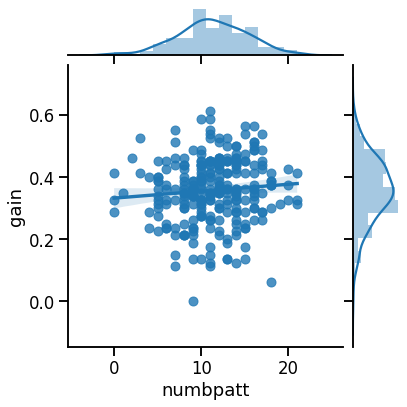

In [158]:
for quest in ['fiveDCR', 'joyexp', 'deprsens','stresstol','ovsoccur','cosoccur', 'thrillseek', 'perccur', 
              'NCS', 'AQ28', 'socskills','routine','switching', 'imagination', 'numbpatt']:
    
    r, p = stats.pearsonr(dfsubj.gain, dfsubj[quest])
    sns.jointplot(x=quest, y="gain", data=dfsubj, kind="reg");
    print(quest,'pearson r =', round(r,3), 'p-value = ', round(p,3))


Only the imagination subscale relates to learning gain.

## Make a correlation matrix with questionnaires

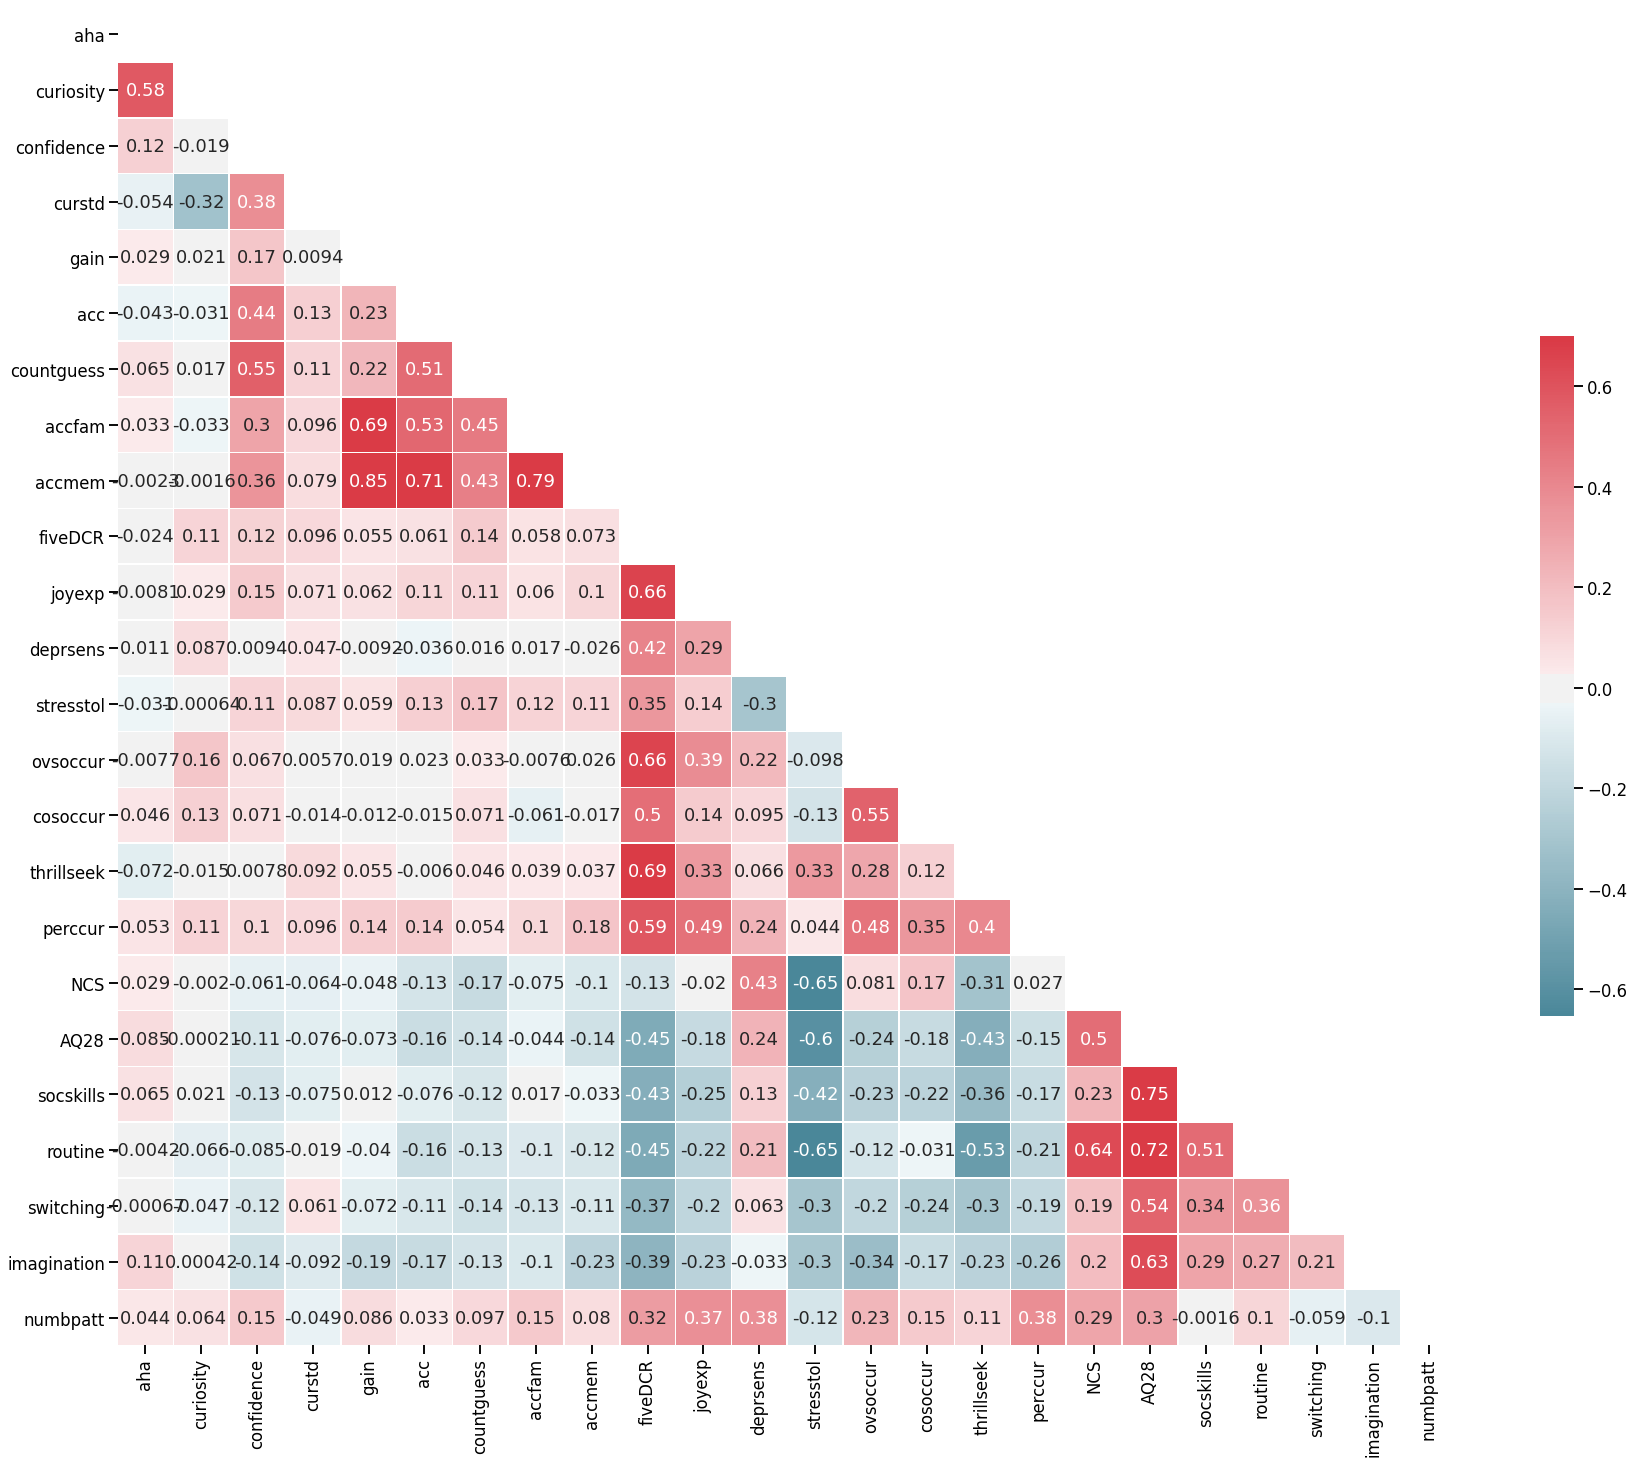

In [165]:
# Compute the correlation matrix
corr = dfsubj[['aha','curiosity', 'confidence','curstd','gain', 'acc', 'countguess', 'accfam', 'accmem','fiveDCR', 'joyexp', 'deprsens','stresstol','ovsoccur','cosoccur', 'thrillseek', 'perccur', 
              'NCS', 'AQ28', 'socskills','routine','switching', 'imagination', 'numbpatt']].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(30, 25))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.7, center=0,
            square=True, linewidths=.5, annot= True, cbar_kws={"shrink": .5});

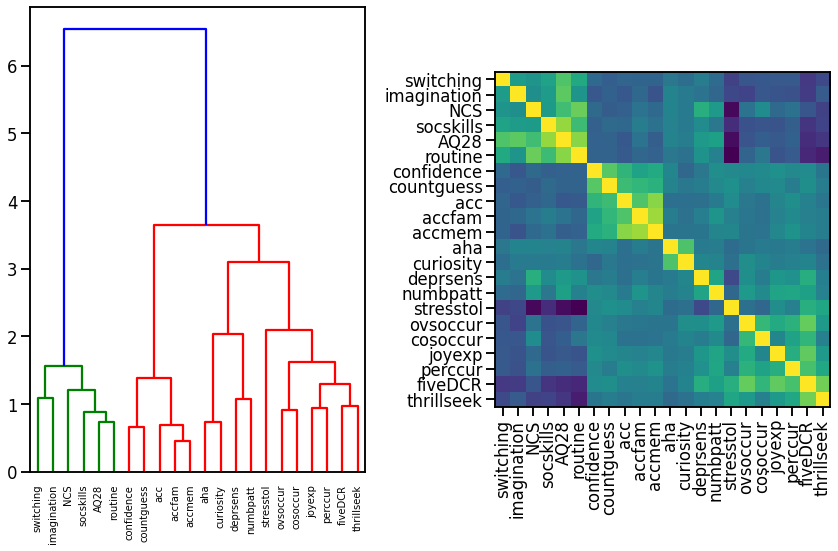

In [90]:
from scipy.stats import spearmanr
from scipy.cluster import hierarchy

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

corr = spearmanr(dfsubj[['aha','curiosity', 'confidence', 'acc', 'countguess', 'accfam', 'accmem','fiveDCR', 'joyexp', 'deprsens','stresstol','ovsoccur','cosoccur', 'thrillseek', 'perccur', 
              'NCS', 'AQ28', 'socskills','routine','switching', 'imagination', 'numbpatt']]).correlation


corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(corr_linkage, labels=dfsubj[['aha','curiosity', 'confidence', 'acc', 'countguess', 'accfam', 'accmem','fiveDCR', 'joyexp', 'deprsens','stresstol','ovsoccur','cosoccur', 'thrillseek', 'perccur', 
              'NCS', 'AQ28', 'socskills','routine','switching', 'imagination', 'numbpatt']].columns, ax=ax1,
                              leaf_rotation=90)
dendro_idx = np.arange(0, len(dendro['ivl']))

ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])
fig.tight_layout()

#### Other things of note:
- The correlations between perceptual curiosity and pre-reveal accuracy or recognition memory may be interesting
- Similar with negative correlations between imagination subscale of the AQ28 and pre-reveal accuracy or recognition memory. Note that high imagination score means more autism-like imagination, so lower actual imagination. Could point to the relevance of one's top-down generative capacity to come up with possible solutions.
- Relatedly, some (low: .15) negative correlations are present between the number of guesses (countguess; irrespective of acc) and imagination/NCS (significant but won't survive correction if needed; cf. planned)

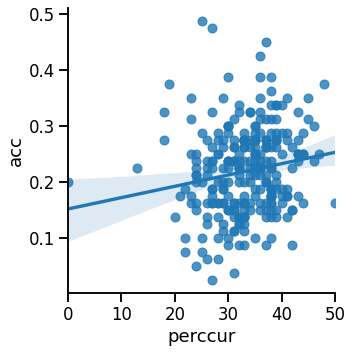

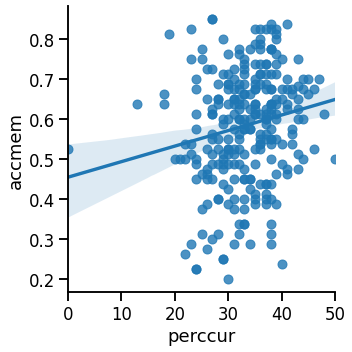

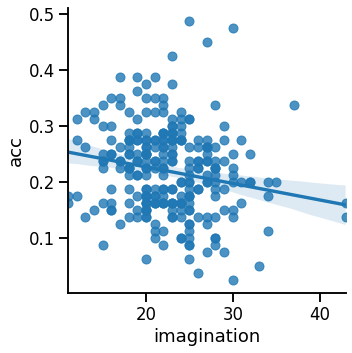

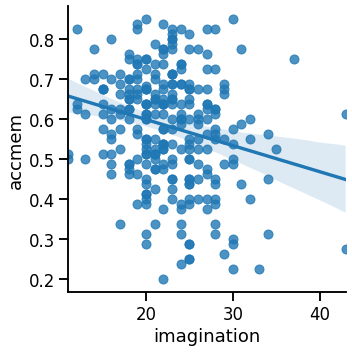

In [141]:
sns.lmplot(x='perccur', y="acc", data=dfsubj, robust=True);
sns.lmplot(x='perccur', y="accmem", data=dfsubj, robust=True);
sns.lmplot(x='imagination', y="acc", data=dfsubj, robust=True);
sns.lmplot(x='imagination', y="accmem", data=dfsubj, robust=True);

## TODO: Relating familiarity d primes to avg curiosity, conf, aha, questionnaires

In [331]:
df.groupby(['subject','old']).accfam.mean() 


subject  old
00000    0      0.7500
         1      0.9375
29689    0      1.0000
         1      0.8625
34174    0      0.9500
                 ...  
40294    1      0.7875
CA       0      1.0000
         1      0.9625
MJ       0      0.8500
         1      0.7750
Name: correct, Length: 424, dtype: float64

# Per image analysis

In [35]:
dfim = df[(df.old==1)].groupby(['currentStim']).agg(
    nbofobs=pd.NamedAgg(column='accfam', aggfunc='count'),
    accfam=pd.NamedAgg(column='accfam', aggfunc='mean'),
    countguess=pd.NamedAgg(column='guess', aggfunc='count'),
    countmem=pd.NamedAgg(column='guessmem', aggfunc='count'),
    accfamstd=pd.NamedAgg(column='accfam', aggfunc='std'),
    acc=pd.NamedAgg(column='acc', aggfunc='mean'),
    accstd=pd.NamedAgg(column='acc', aggfunc='std'),
    accmem=pd.NamedAgg(column='accmem', aggfunc='mean'),
    accmemstd=pd.NamedAgg(column='accmem', aggfunc='std'),
    confidence=pd.NamedAgg(column='confidence', aggfunc='mean'),
    confstd=pd.NamedAgg(column='confidence', aggfunc='std'),
    curiosity=pd.NamedAgg(column='curiosity', aggfunc='mean'),
    curstd=pd.NamedAgg(column='curiosity', aggfunc='std'),
    aha=pd.NamedAgg(column='aha', aggfunc='mean'),
    ahastd=pd.NamedAgg(column='aha', aggfunc='std')).reset_index()

dfimacc = df[(df.old==1)].groupby(['currentStim', 'acc']).agg(
    nbofobs=pd.NamedAgg(column='accfam', aggfunc='count'),
    accfam=pd.NamedAgg(column='accfam', aggfunc='mean'),
    countguess=pd.NamedAgg(column='guess', aggfunc='count'),
    countmem=pd.NamedAgg(column='guessmem', aggfunc='count'),
    accfamstd=pd.NamedAgg(column='accfam', aggfunc='std'),
    #acc=pd.NamedAgg(column='acc', aggfunc='mean'),
    #accstd=pd.NamedAgg(column='acc', aggfunc='std'),
    accmem=pd.NamedAgg(column='accmem', aggfunc='mean'),
    accmemstd=pd.NamedAgg(column='accmem', aggfunc='std'),
    confidence=pd.NamedAgg(column='confidence', aggfunc='mean'),
    confstd=pd.NamedAgg(column='confidence', aggfunc='std'),
    curiosity=pd.NamedAgg(column='curiosity', aggfunc='mean'),
    curstd=pd.NamedAgg(column='curiosity', aggfunc='std'),
    aha=pd.NamedAgg(column='aha', aggfunc='mean'),
    ahastd=pd.NamedAgg(column='aha', aggfunc='std')).reset_index()

In [9]:
#nb of observations per image
dfim.nbofobs.mean()

110.34482758620689

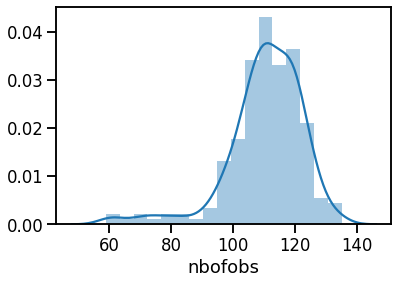

In [10]:
sns.distplot(dfim.nbofobs)

Make new var for percentage of people that have made a guess for a given image

In [25]:
dfim['percguess'] = dfim.countguess/dfim.nbofobs
dfim['percmemguess'] = dfim.countmem/dfim.nbofobs
dfim.head()

currentStim  nbofobs    accfam  countguess  countmem  accfamstd  \
0  ../img/tt/001tt.jpg      110  0.663636          85        85   0.474627   
1  ../img/tt/007tt.jpg      111  0.855856          81        95   0.352829   
2  ../img/tt/008tt.jpg       98  0.897959          76        83   0.304258   
3  ../img/tt/010tt.jpg      128  0.843750          83        77   0.364519   
4  ../img/tt/013tt.jpg      117  0.495726          63        66   0.502132   

        acc    accstd    accmem  accmemstd  confidence   confstd  curiosity  \
0  0.154545  0.363125  0.509091   0.502205    1.581818  1.610640   4.145455   
1  0.189189  0.393435  0.729730   0.446113    1.702703  1.786793   4.216216   
2  0.316327  0.467433  0.744898   0.438160    1.255102  1.341727   4.051020   
3  0.015625  0.124507  0.304688   0.462084    0.882812  1.091276   4.015625   
4  0.145299  0.353918  0.393162   0.490553    0.965812  1.569821   4.170940   

     curstd       aha    ahastd  percguess  percmemguess  
0  1.507391  3.200000  2.003666   0.772727      0.772727  
1  1.603436  3.180180  2.081076   0.729730      0.855856  
2  1.620567  3.551020  1.693666   0.775510      0.846939  
3  1.640935  3.203125  2.032645   0.648438      0.601562  
4  1.713489  3.931624  1.950802   0.538462      0.564103

In [150]:
len(dfim[dfim.aha>3.75])

21

In [26]:
dfrel = df[['subject','currentStim', 'aha']]

dfrel = dfrel.sort_values(["subject", "currentStim"], ascending = (True, True))

dfrel = dfrel.pivot(index='subject', columns='currentStim', values='aha').reset_index()

dfrel

currentStim subject  ../img/tt/001tt.jpg  ../img/tt/007tt.jpg  \
0             00000                  3.0                  NaN   
1             29689                  NaN                  2.0   
2             33928                  NaN                  5.0   
3             34003                  4.0                  2.0   
4             34174                  NaN                  5.0   
..              ...                  ...                  ...   
274           40159                  NaN                  1.0   
275           40201                  0.0                  3.0   
276           40294                  5.0                  NaN   
277              CA                  6.0                  1.0   
278              MJ                  5.0                  5.0   

currentStim  ../img/tt/008tt.jpg  ../img/tt/010tt.jpg  ../img/tt/013tt.jpg  \
0                            4.0                  NaN                  5.0   
1                            NaN                  NaN                  5.0   
2                            5.0                  NaN                  5.0   
3                            4.0                  NaN                  NaN   
4                            6.0                  NaN                  NaN   
..                           ...                  ...                  ...   
274                          6.0                  0.0                  NaN   
275                          NaN                  NaN                  NaN   
276                          NaN                  NaN                  NaN   
277                          NaN                  NaN                  NaN   
278                          NaN                  NaN                  6.0   

currentStim  ../img/tt/019tt.jpg  ../img/tt/020tt.jpg  ../img/tt/031tt.jpg  \
0                            4.0                  3.0                  NaN   
1                            3.0                  4.0                  NaN   
2                            6.0                  NaN                  NaN   
3                            6.0                  4.0                  NaN   
4                            NaN                  6.0                  NaN   
..                           ...                  ...                  ...   
274                          NaN                  NaN                  NaN   
275                          0.0                  NaN                  2.0   
276                          NaN                  3.0                  2.0   
277                          1.0                  4.0                  1.0   
278                          NaN                  NaN                  NaN   

currentStim  ../img/tt/032tt.jpg  ...  ../img/tt/549tt.jpg  \
0                            NaN  ...                  NaN   
1                            NaN  ...                  1.0   
2                            NaN  ...                  1.0   
3                            5.0  ...                  NaN   
4                            6.0  ...                  NaN   
..                           ...  ...                  ...   
274                          NaN  ...                  NaN   
275                          4.0  ...                  0.0   
276                          NaN  ...                  NaN   
277                          NaN  ...                  NaN   
278                          5.0  ...                  2.0   

currentStim  ../img/tt/552tt.jpg  ../img/tt/559tt.jpg  ../img/tt/567tt.jpg  \
0                            5.0                  NaN                  4.0   
1                            NaN                  NaN                  NaN   
2                            4.0                  1.0                  NaN   
3                            NaN                  NaN                  NaN   
4                            NaN                  NaN                  NaN   
..                           ...                  ...                  ...   
274                          NaN                  NaN 

## Does avg curiosity of image relate to its avg aha strength or confidence?

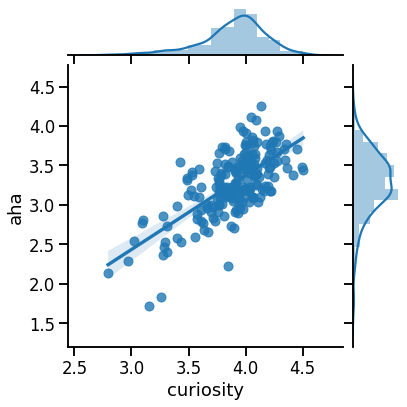

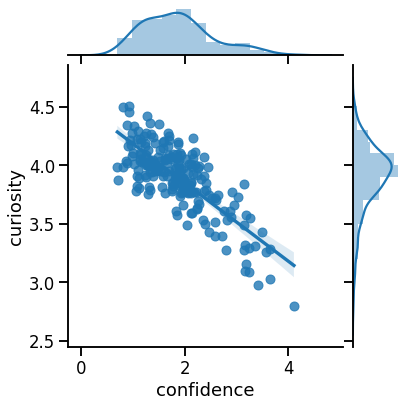

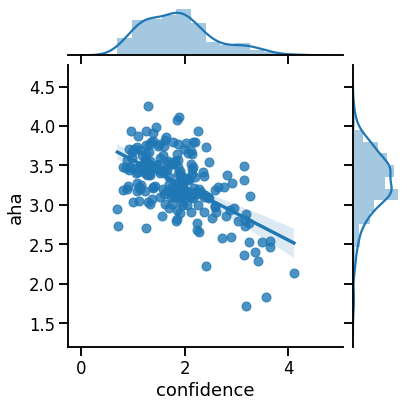

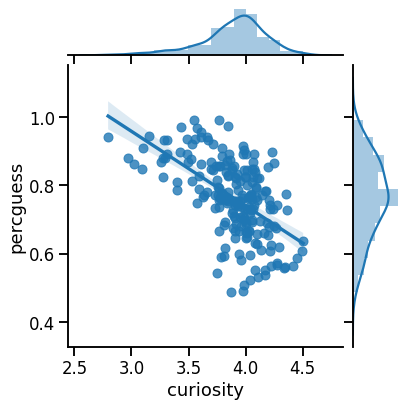

In [27]:
sns.jointplot(x="curiosity", y="aha", data=dfim, kind="reg");
sns.jointplot(x="confidence", y="curiosity", data=dfim, kind="reg");
sns.jointplot(x="confidence", y="aha", data=dfim, kind="reg");
sns.jointplot(x="curiosity", y="percguess", data=dfim, kind="reg");

- Avg img curiosity is strongly positively related to avg im aha strength.
- Avg img confidence is strongly negatively related to avg im curiosity.
- No link between image confidence and image aha.
- Higher curiosity of the image means lower percentage of people have made a guess

## Does higher image aha mean higher image recognition memory?

pearson r = -0.489 p-value =  0.0


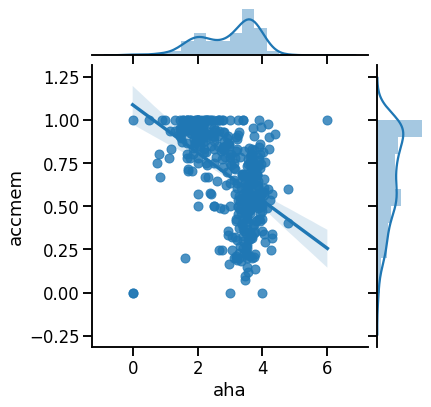

In [32]:
sns.jointplot(x="aha", y="accmem", data=dfim, kind="reg");

r, p = stats.pearsonr(dfim.aha, dfim.accmem)
print('pearson r =', round(r,3), 'p-value = ', round(p,3))


Yes, it does.

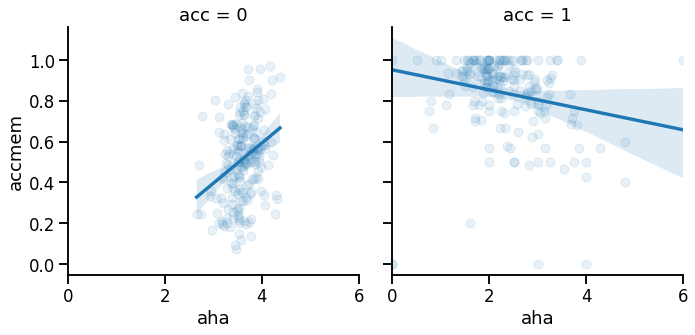

In [36]:
sns.lmplot(x="aha", y="accmem", col='acc', scatter_kws={'alpha':0.1}, data=dfimacc);

Indeed, the acc=0 images are clearly higher in aha (smaller range). Despite the limited range, the aha effect on memory is clearly there. All this also points to some consistency in what images people find aha-eliciting (and memorable). Though I guess this should be tested formally with an interrater reliability measure: https://stackoverflow.com/questions/11528150/inter-rater-agreement-in-python-cohens-kappa

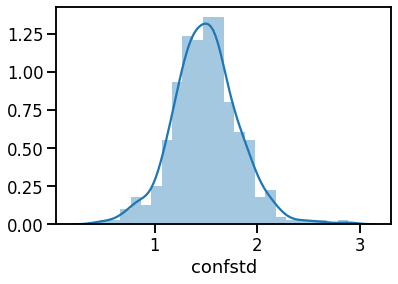

In [317]:
sns.distplot(dfim.confstd)

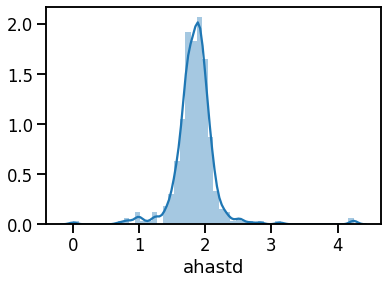

In [318]:
sns.distplot(dfim.ahastd)

## Make column to merge complexity measures on

In [37]:
dfim['imgName'] = dfim.currentStim.str.extract('(\d+)')
dfim['imgName'] = dfim['imgName'].astype(int)


In [30]:
dfim.head()

currentStim   correct  correctstd      conf   confstd       cur  \
0  ../img/tt/001tt.jpg  0.707071    0.457422  1.415584  1.489884  4.142857   
1  ../img/tt/007tt.jpg  0.833333    0.374415  1.559524  1.731015  4.261905   
2  ../img/tt/008tt.jpg  0.884211    0.321670  1.333333  1.433994  4.055556   
3  ../img/tt/010tt.jpg  0.871795    0.335756  0.834951  1.085529  4.048544   
4  ../img/tt/013tt.jpg  0.614035    0.488972  1.021739  1.663957  4.065217   

     curstd       aha    ahastd  imgName  
0  1.545062  3.220779  1.930526        1  
1  1.591537  3.119048  2.130698        7  
2  1.652049  3.583333  1.633712        8  
3  1.670850  3.174757  2.069513       10  
4  1.808432  3.891304  2.018903       13

In [44]:
dfimacc['imgName'] = dfimacc.currentStim.str.extract('(\d+)')
dfimacc['imgName'] = dfimacc['imgName'].astype(int)

## Read in complexity measures

In [38]:
dfc = pd.read_csv('../complexity_measures/mooneyFeatures.csv')

In [28]:
dfc.head()

imgName  entropyMooney  entropyGrayscale  structSim  selfSimilarityMooney  \
0        1       1.756312          7.350505   0.354134               0.52439   
1        7       3.046183          7.834113   0.176417               0.65547   
2        8       2.098715          7.739233   0.304084               0.51810   
3        9       1.867433          7.753575   0.336164               0.44506   
4       10       1.597833          5.565031   0.090799               0.41812   

   selfSimilarityGrayscale  PHOGcomplexityMooney  PHOGcomplexityGrayscale  \
0                  0.56992                6.2874                  21.0880   
1                  0.67581               10.7960                  14.3860   
2                  0.53891                9.2955                  11.0410   
3                  0.44753                7.3215                   4.3294   
4                  0.54948                6.2084                   7.2984   

   anisotropyMooney  anisotropyGrayscale  edgeEntropyMooney  \
0          0.001429             0.001260           0.182302   
1          0.000691             0.000292           0.259272   
2          0.001570             0.000695           0.221323   
3          0.001745             0.001266           0.193137   
4          0.001604             0.000822           0.183774   

   edgeEntropyGrayscale  
0              0.573023  
1              0.565986  
2              0.407314  
3              0.271203  
4              0.478438

## Merge data of pretest and complexity measures

In [39]:
dfim= pd.merge(dfim, dfc, how='left', on='imgName')
dfim.head()

currentStim  nbofobs    accfam  countguess  countmem  accfamstd  \
0  ../img/tt/001tt.jpg      110  0.663636          85        85   0.474627   
1  ../img/tt/007tt.jpg      111  0.855856          81        95   0.352829   
2  ../img/tt/008tt.jpg       98  0.897959          76        83   0.304258   
3  ../img/tt/010tt.jpg      128  0.843750          83        77   0.364519   
4  ../img/tt/013tt.jpg      117  0.495726          63        66   0.502132   

        acc    accstd    accmem  accmemstd  ...  entropyGrayscale  structSim  \
0  0.154545  0.363125  0.509091   0.502205  ...          7.350505   0.354134   
1  0.189189  0.393435  0.729730   0.446113  ...          7.834113   0.176417   
2  0.316327  0.467433  0.744898   0.438160  ...          7.739233   0.304084   
3  0.015625  0.124507  0.304688   0.462084  ...          5.565031   0.090799   
4  0.145299  0.353918  0.393162   0.490553  ...          7.754878   0.302509   

   selfSimilarityMooney  selfSimilarityGrayscale  PHOGcomplexityMooney  \
0               0.52439                  0.56992                6.2874   
1               0.65547                  0.67581               10.7960   
2               0.51810                  0.53891                9.2955   
3               0.41812                  0.54948                6.2084   
4               0.57103                  0.73293                8.3549   

   PHOGcomplexityGrayscale  anisotropyMooney  anisotropyGrayscale  \
0                  21.0880          0.001429             0.001260   
1                  14.3860          0.000691             0.000292   
2                  11.0410          0.001570             0.000695   
3                   7.2984          0.001604             0.000822   
4                  12.2840          0.001264             0.000585   

   edgeEntropyMooney  edgeEntropyGrayscale  
0           0.182302              0.573023  
1           0.259272              0.565986  
2           0.221323              0.407314  
3           0.183774              0.478438  
4           0.212878              0.516667  

[5 rows x 28 columns]

In [45]:
dfimacc= pd.merge(dfimacc, dfc, how='left', on='imgName')


pearson r = 0.621 p-value =  0.0


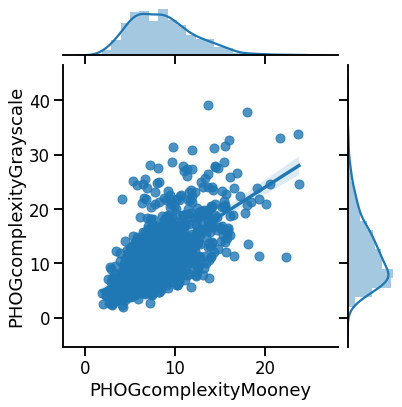

In [40]:
sns.jointplot(x="PHOGcomplexityMooney", y="PHOGcomplexityGrayscale", data=dfc, kind="reg");
r, p = stats.pearsonr(dfc.PHOGcomplexityMooney, dfc.PHOGcomplexityGrayscale)
print('pearson r =', round(r,3), 'p-value = ', round(p,3))

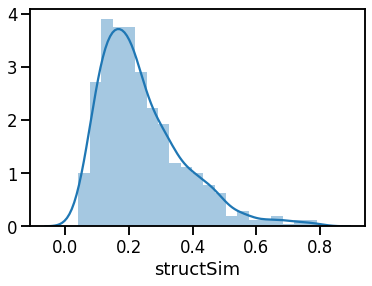

In [41]:
sns.distplot(dfc.structSim)

## Is there a correlation between structural similarity (mooney and grayscale) and recognition/familiarity/memory?

pearson r = -0.015 p-value =  0.828


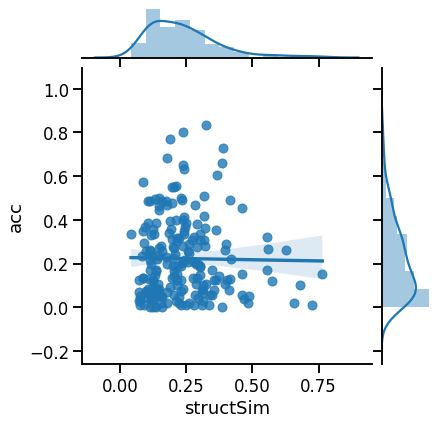

In [168]:
sns.jointplot(x="structSim", y="acc", data=dfim, kind="reg");

r, p = stats.pearsonr(dfim.structSim, dfim.acc)
print('pearson r =', round(r,3), 'p-value = ', round(p,3))

pearson r = 0.211 p-value =  0.002


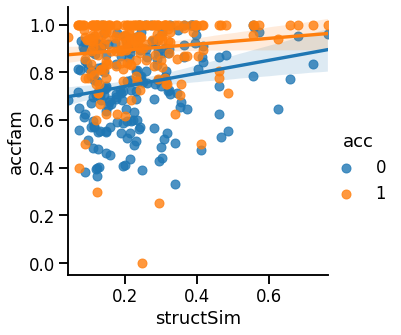

In [47]:
sns.lmplot(x="structSim", y="accfam",hue='acc', data=dfimacc);

r, p = stats.pearsonr(dfimacc[dfimacc.acc==0].structSim, dfimacc[dfimacc.acc==0].accfam)
print('pearson r =', round(r,3), 'p-value = ', round(p,3))

pearson r = 0.189 p-value =  0.007


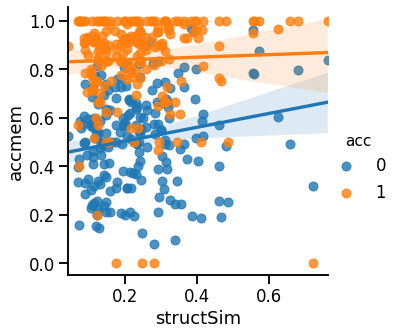

In [222]:
sns.lmplot(x="structSim", y="accmem",hue="acc", data=dfim);

r, p = stats.pearsonr(dfim[dfim.acc==0].structSim, dfim[dfim.acc==0].accmem)
print('pearson r =', round(r,3), 'p-value = ', round(p,3))

Struct sim does relate positively with post-reveal familiarity and recognition memory, but only for acc=0. Still interestingthat the effect isn't there for the first guess (acc), if structsim is a measure of obviousness, but structsim might only help when you've already seen the solution (similar features become actual cues).

## Does struct sim predict confidence, curiosity, aha?

aha: pearson r = -0.061 p-value =  0.226
curiosity: pearson r = -0.128 p-value =  0.01
confidence: pearson r = 0.079 p-value =  0.116


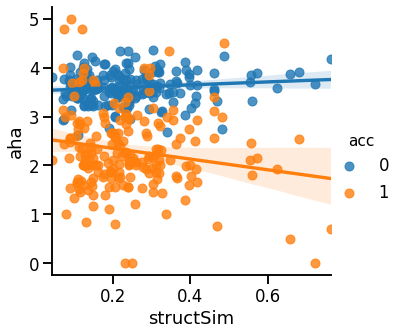

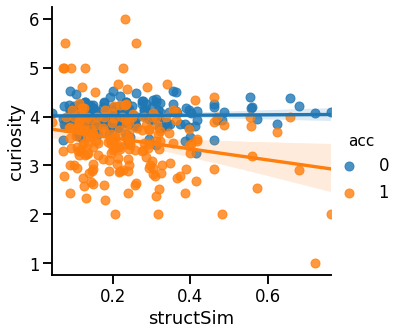

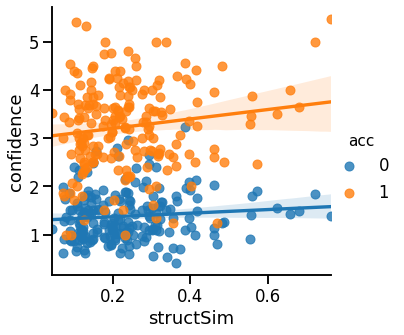

In [213]:
sns.lmplot(x="structSim", y="aha", hue='acc', data=dfim);
sns.lmplot(x="structSim", y="curiosity", hue='acc', data=dfim);
sns.lmplot(x="structSim", y="confidence", hue='acc', data=dfim);
r, p = stats.pearsonr(dfim.structSim, dfim.aha)
print('aha: pearson r =', round(r,3), 'p-value = ', round(p,3))
r, p = stats.pearsonr(dfim.structSim, dfim.curiosity)
print('curiosity: pearson r =', round(r,3), 'p-value = ', round(p,3))
r, p = stats.pearsonr(dfim.structSim, dfim.confidence)
print('confidence: pearson r =', round(r,3), 'p-value = ', round(p,3))

Nope. To test: if image was accurately identified, higher struct sim means lower curiosity/aha (makes sense, captures the obviousness of the content in the Mooney?).

In principle one could have expected an inverted u-shape relation between structsim and aha: low aha for very structsimilar images (obviousness) and very structunsimilar (mooney and solution don't match at all, even after reveal), but that isn't the case. Suggests that structsim does not capture the processing chars that determine aha (which surely has to do with top-down aspects as well).

## Make correlation matrix

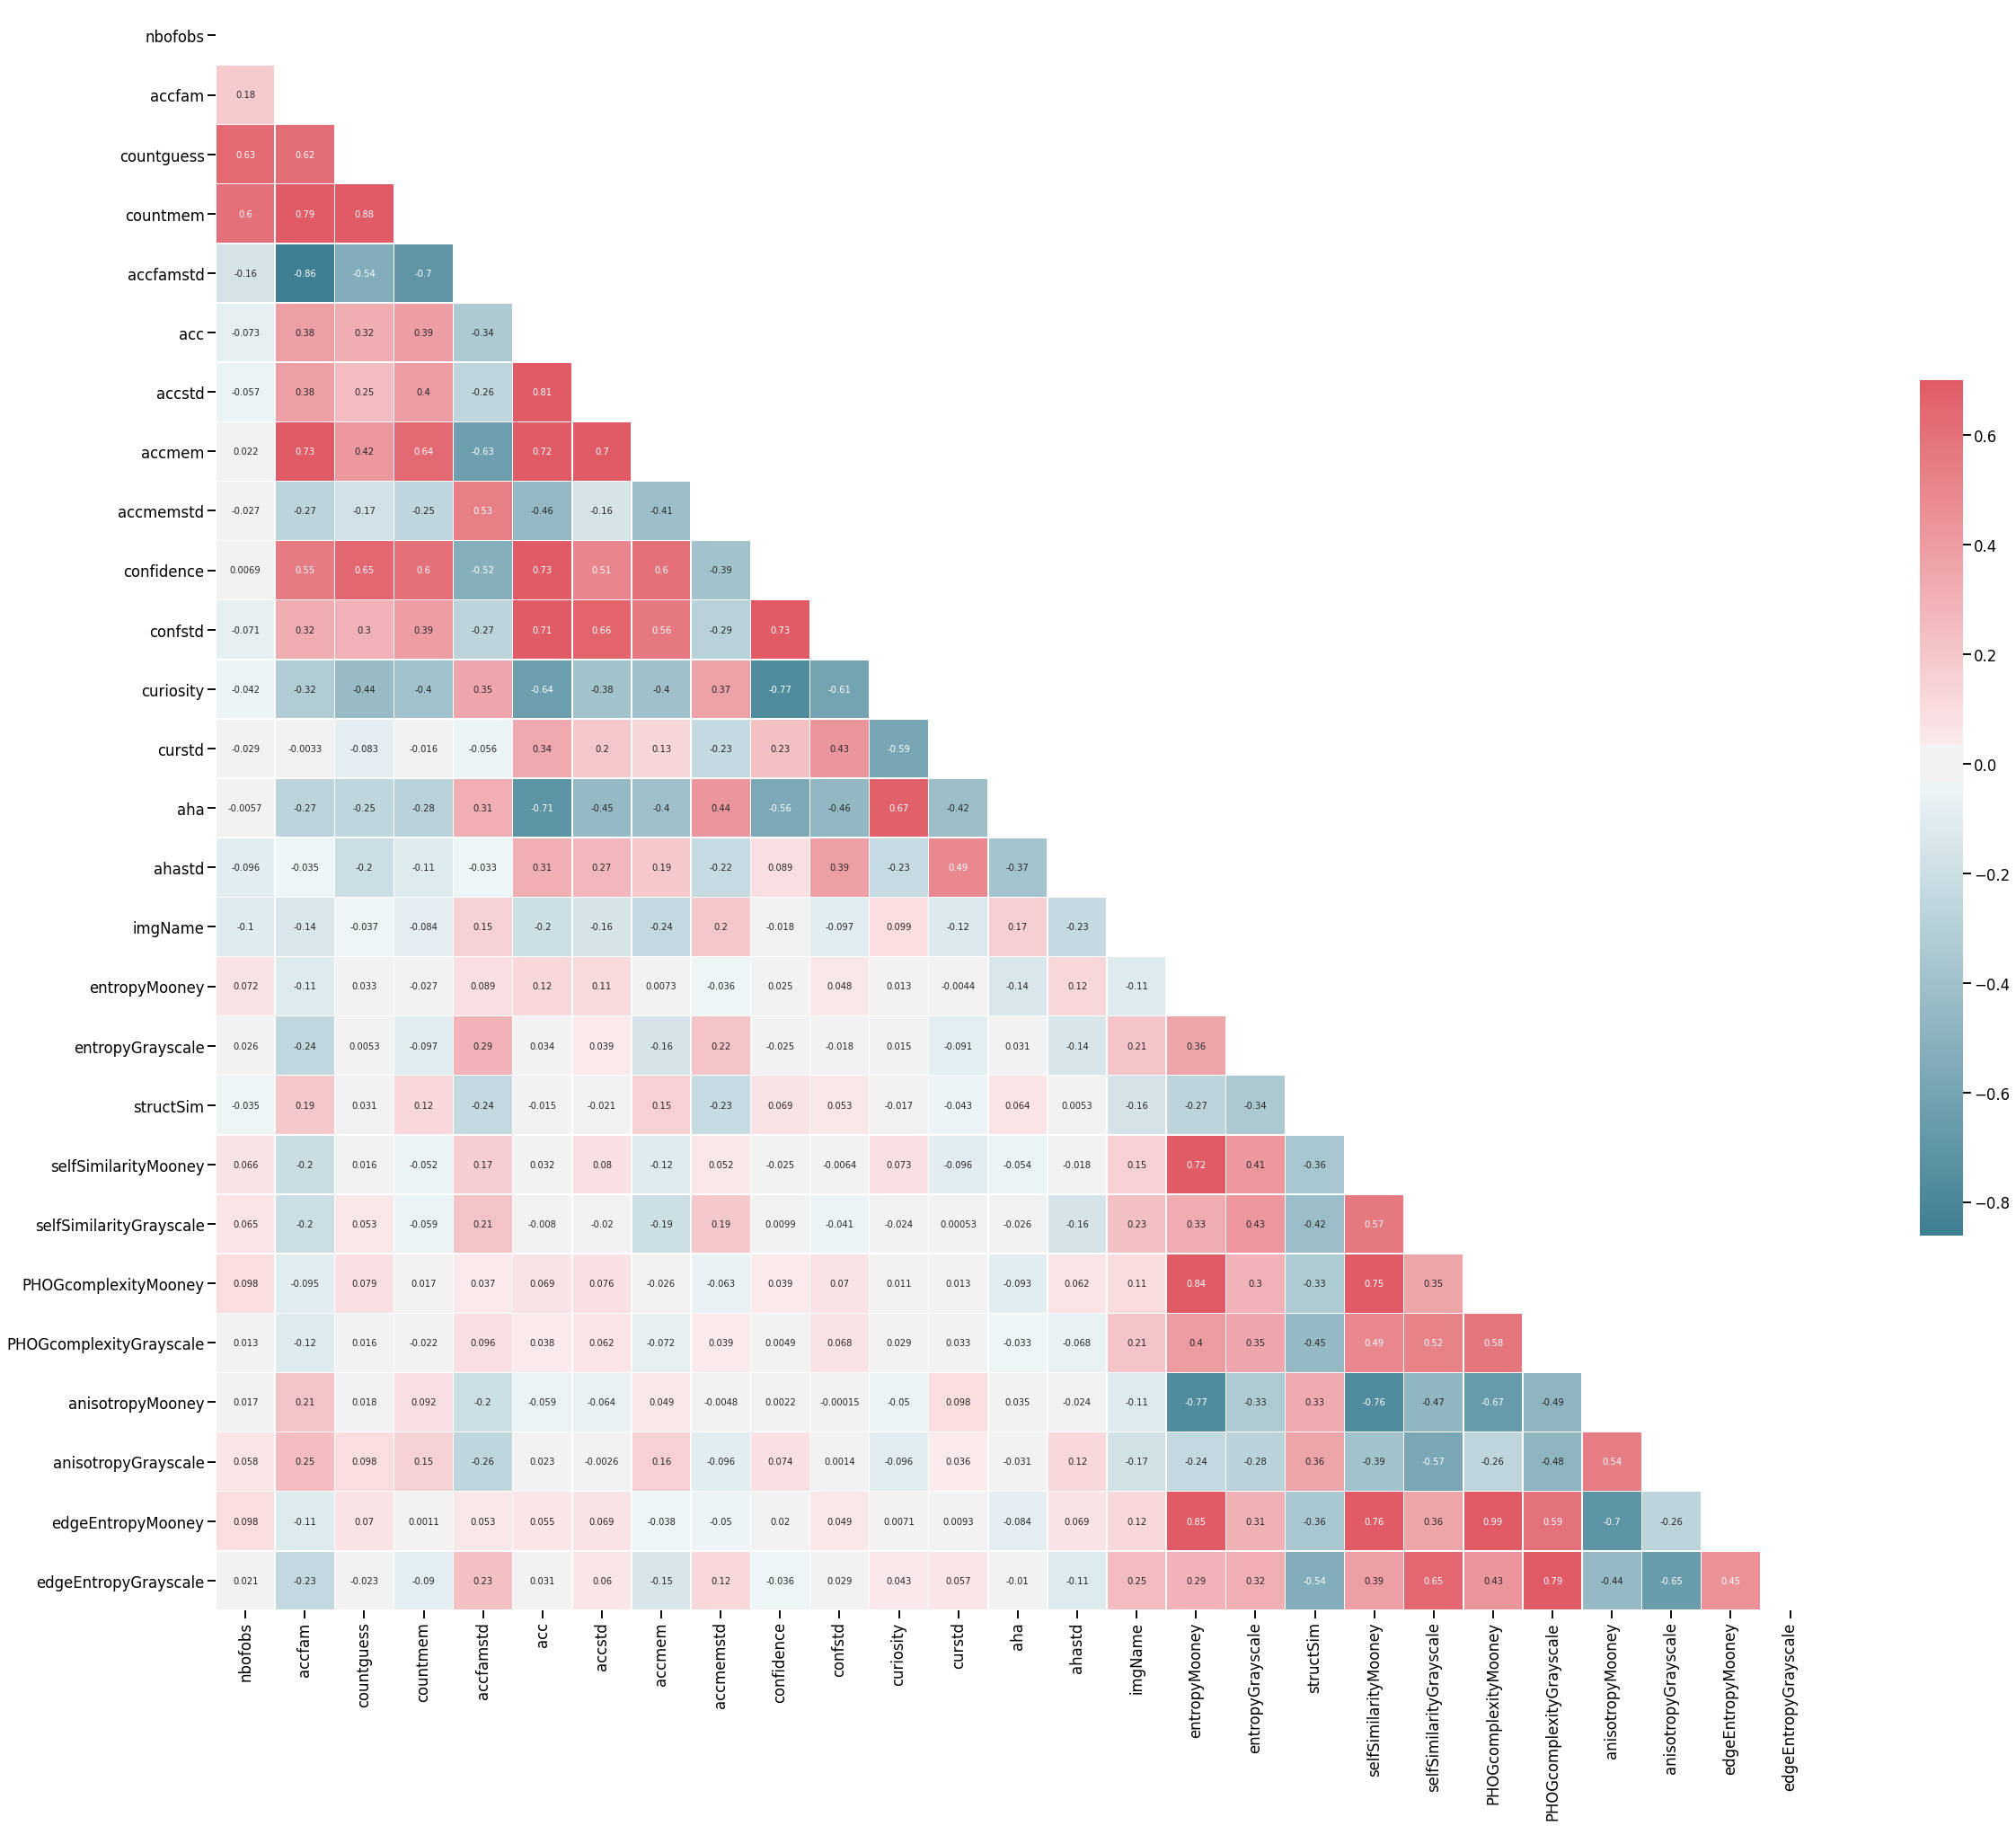

In [171]:
# Compute the correlation matrix
corr = dfim.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(40, 35))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.7, center=0,
            square=True, linewidths=.5, annot= True, cbar_kws={"shrink": .5});

Other things to note:
- Mooney familiarity (accfam) seems to be related to several complexity measures (>.2)
- A subset of those also correlate with recognition memory (though usually less so: .12-.2).
- Anisotropy and self-similarity seem to be dominant here (why? Some indeed capture human visual processing better, at least in terms of having higher correlations with human ratings of complexity (which could be considered as kind of the opposite of fluency). Anisotropy and Self-similarity tend to be better than Entropy, for example.)
- self-similarity is actually negatively correlated with memory. So actually, the higher complexity images are remembered better. Could be an interest thing, since our images weren’t that complex anyway (usually just one animal or type of food in the centre).
- Remains to be seen how much of this survives corrected alpha level. For example (10 complexity measures: alpha= .05/10=.005), selfsim with accmem would be significant, while anisotropy would not (see below). Roughly, it seems a correlation of around .20 is needed to be significant.
- I think we can argue that we had an hypothesis about struct sim and recognition memory (so this can be uncorrected), but not for all other (single image) complexity measures.


selfSimilarityGrayscale: pearson r = -0.19 p-value =  0.007
anisotropyGrayscale: pearson r = 0.157 p-value =  0.025


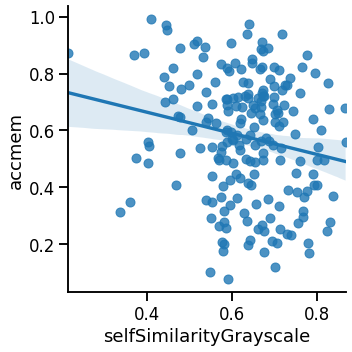

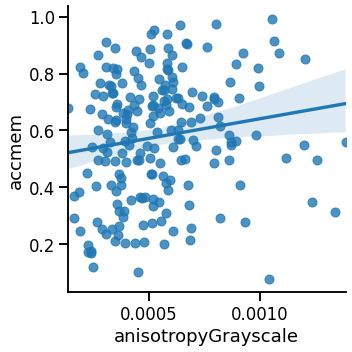

In [172]:
sns.lmplot(x="selfSimilarityGrayscale", y="accmem", data=dfim);
r, p = stats.pearsonr(dfim.selfSimilarityGrayscale, dfim.accmem)
print('selfSimilarityGrayscale: pearson r =', round(r,3), 'p-value = ', round(p,3))

sns.lmplot(x="anisotropyGrayscale", y="accmem", data=dfim);
r, p = stats.pearsonr(dfim.anisotropyGrayscale, dfim.accmem)
print('anisotropyGrayscale: pearson r =', round(r,3), 'p-value = ', round(p,3))

## Distribution of the (complexity) measures?

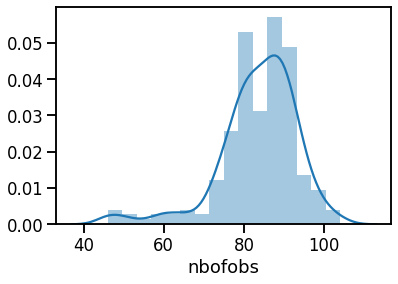

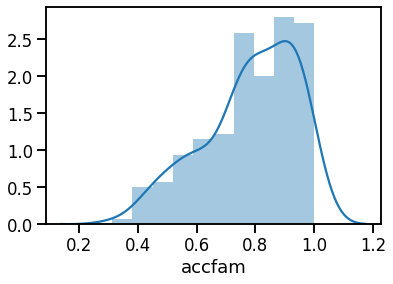

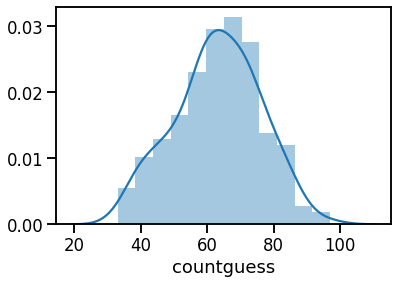

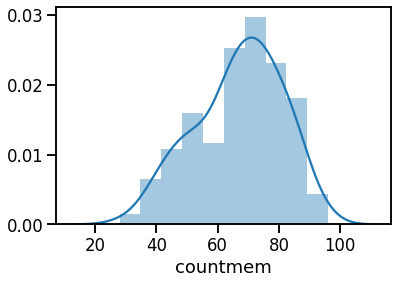

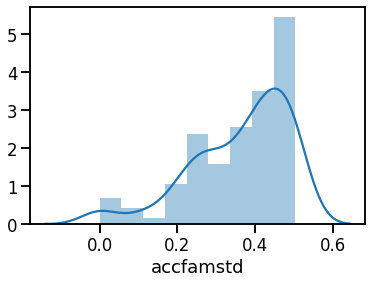

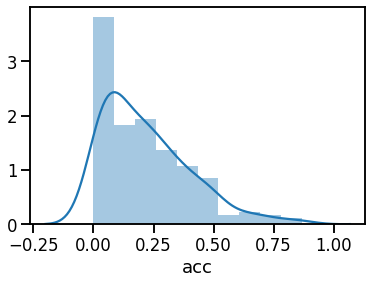

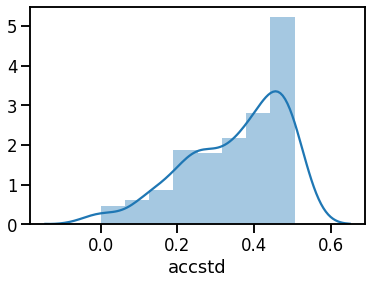

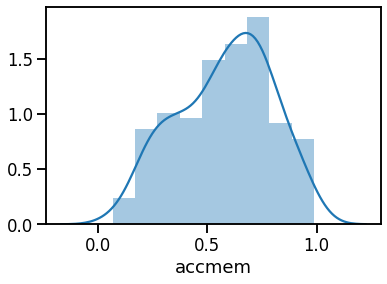

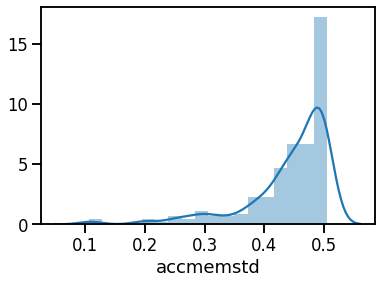

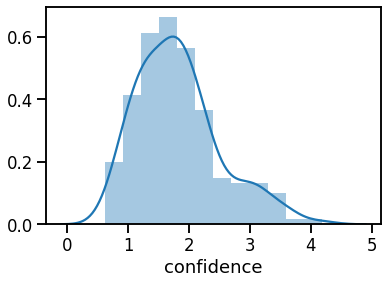

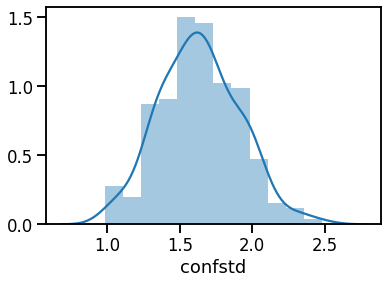

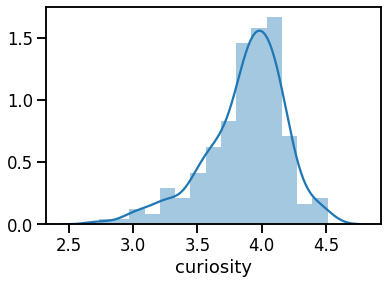

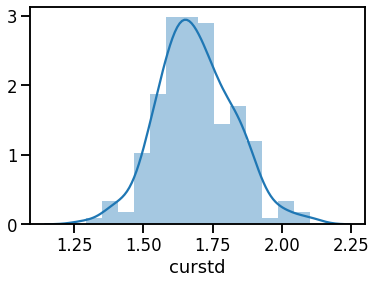

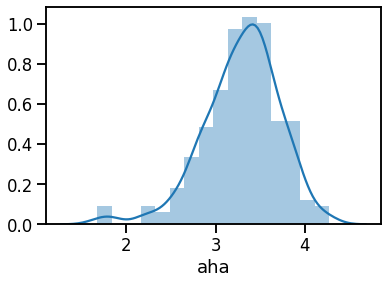

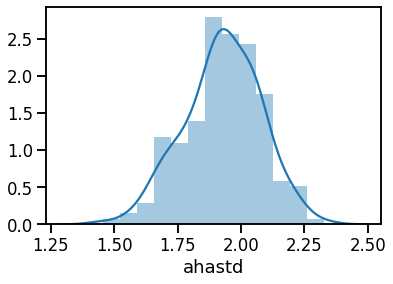

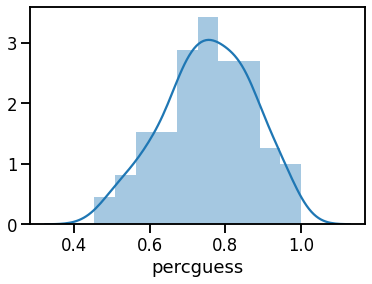

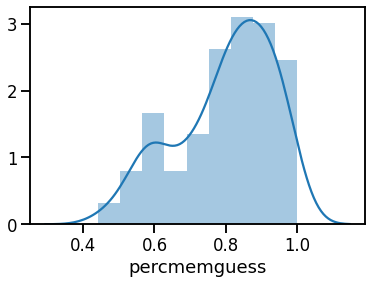

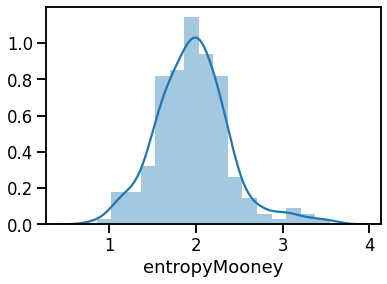

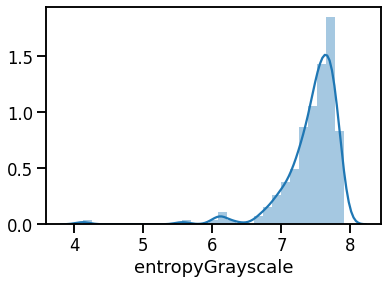

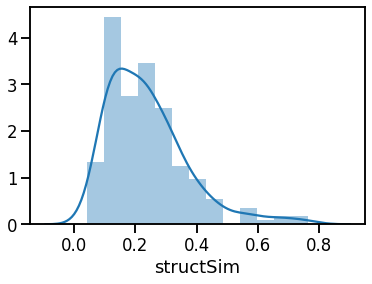

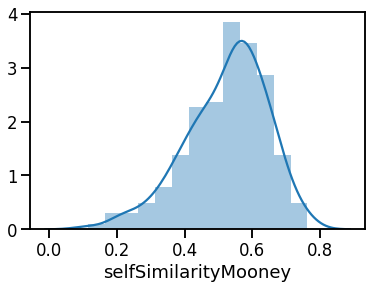

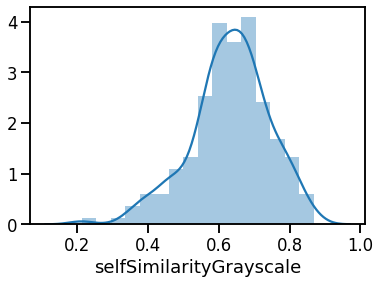

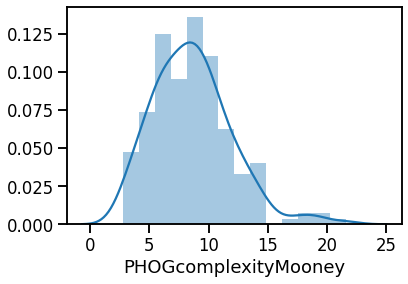

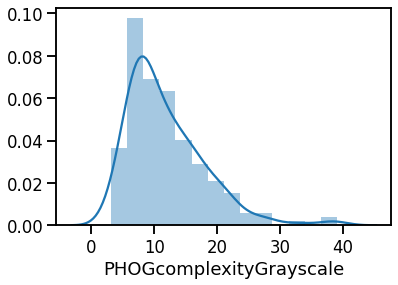

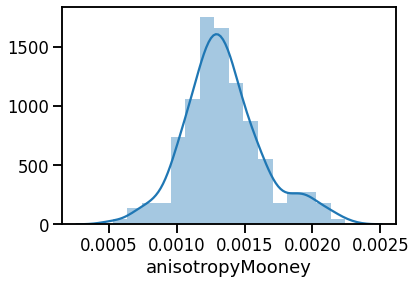

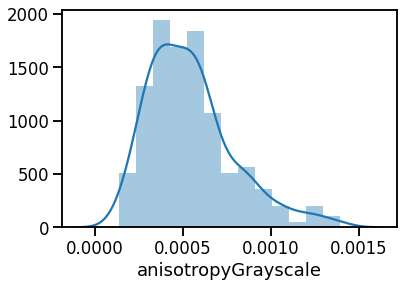

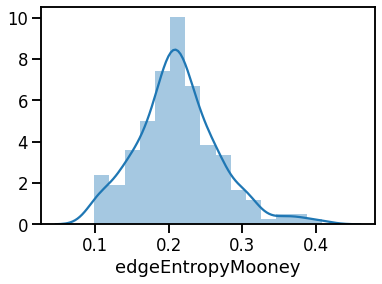

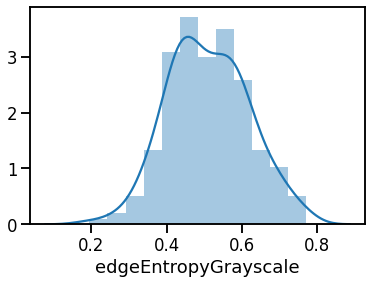

In [405]:

for measure in dfim.columns:
    if measure== 'currentStim' or measure =='imgName': 
        continue
    plt.figure()
    sns.distplot(dfim[measure])
   

## Memorability scores

match memcat names and merge with dfim

In [48]:
dfmatchnames = pd.read_csv('matchedimgnames.csv', index_col=0)
dfmatchnames.mooneyname = dfmatchnames.mooneyname.str.replace('gs', 'tt')
dfmatchnames['mooneyname'] = '../img/tt/' + dfmatchnames['mooneyname'].astype(str)
dfim = pd.merge(dfim, dfmatchnames, how='left', left_on='currentStim', right_on='mooneyname')
print('number of images with memorability info (203 total):',dfim.memcatname.isnull().sum())
dfmem = pd.read_csv('memcat_image_data.csv', index_col=0)
dfim = pd.merge(dfim, dfmem, how='left', left_on='memcatname', right_on='image_file')

number of images with memorability info (203 total): 98


In [59]:
dfimacc = pd.merge(dfimacc, dfmatchnames, how='left', left_on='currentStim', right_on='mooneyname')
dfimacc = pd.merge(dfimacc, dfmem, how='left', left_on='memcatname', right_on='image_file')

### Is there a correlation between first guess accuracy and memorability score?

pearson r = 0.098 p-value =  0.322


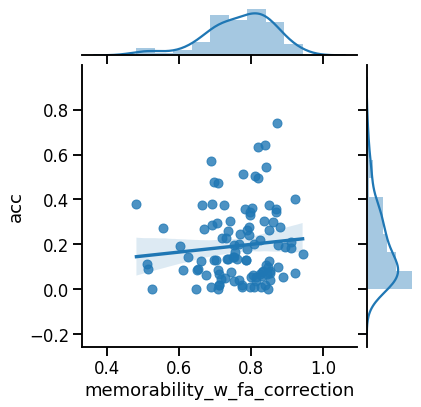

In [49]:
sns.jointplot(x="memorability_w_fa_correction", y="acc", data=dfim, kind="reg");

r, p = stats.pearsonr(dfim.dropna().memorability_w_fa_correction, dfim.dropna().acc)
print('pearson r =', round(r,3), 'p-value = ', round(p,3))

### Is there a correlation between recognition memory accuracy and memorability score?

pearson r = 0.243 p-value =  0.013


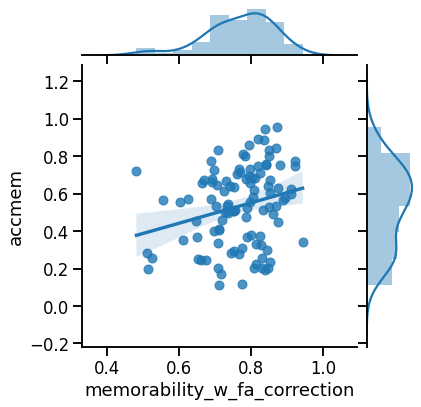

In [50]:
sns.jointplot(x="memorability_w_fa_correction", y="accmem", data=dfim, kind="reg");

r, p = stats.pearsonr(dfim.dropna().memorability_w_fa_correction, dfim.dropna().accmem)
print('pearson r =', round(r,3), 'p-value = ', round(p,3))

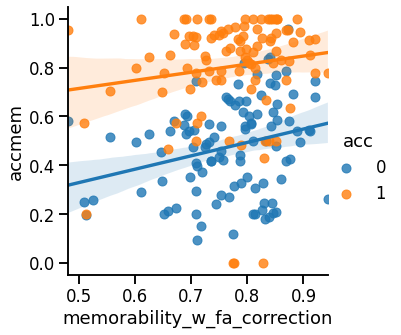

In [60]:
sns.lmplot(x="memorability_w_fa_correction", y="accmem",hue='acc', data=dfimacc);

### Is there a correlation between familiarity accuracy and memorability score?

pearson r = 0.148 p-value =  0.132


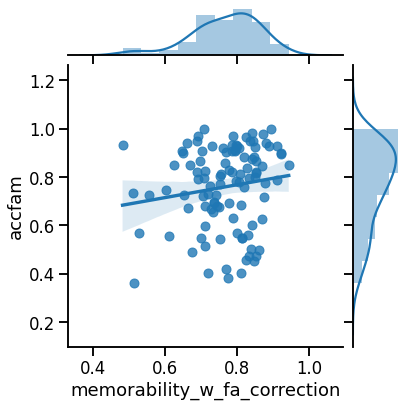

In [51]:
sns.jointplot(x="memorability_w_fa_correction", y="accfam", data=dfim, kind="reg");

r, p = stats.pearsonr(dfim.dropna().memorability_w_fa_correction, dfim.dropna().accfam)
print('pearson r =', round(r,3), 'p-value = ', round(p,3))

### Is there a correlation between curiosity or aha and memorability score?

pearson r = 0.045 p-value =  0.65


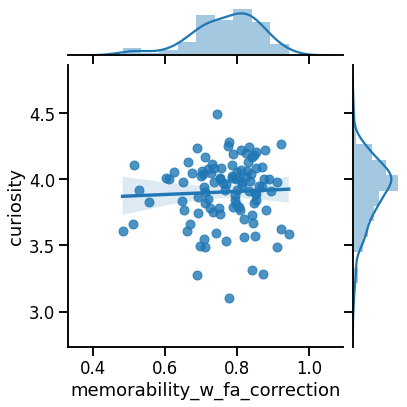

In [52]:
sns.jointplot(x="memorability_w_fa_correction", y="curiosity", data=dfim, kind="reg");

r, p = stats.pearsonr(dfim.dropna().memorability_w_fa_correction, dfim.dropna().curiosity)
print('pearson r =', round(r,3), 'p-value = ', round(p,3))

pearson r = 0.014 p-value =  0.89


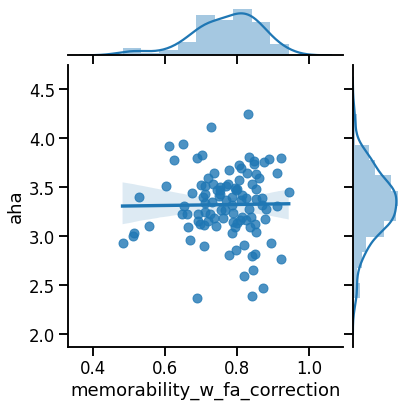

In [53]:
sns.jointplot(x="memorability_w_fa_correction", y="aha", data=dfim, kind="reg");

r, p = stats.pearsonr(dfim.dropna().memorability_w_fa_correction, dfim.dropna().aha)
print('pearson r =', round(r,3), 'p-value = ', round(p,3))

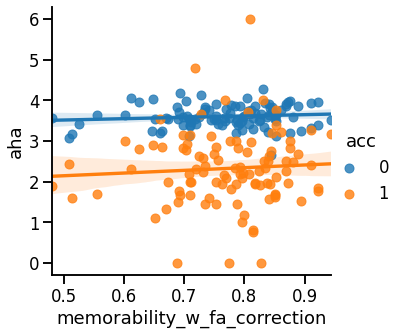

In [61]:
sns.lmplot(x="memorability_w_fa_correction", y="aha",hue='acc', data=dfimacc);

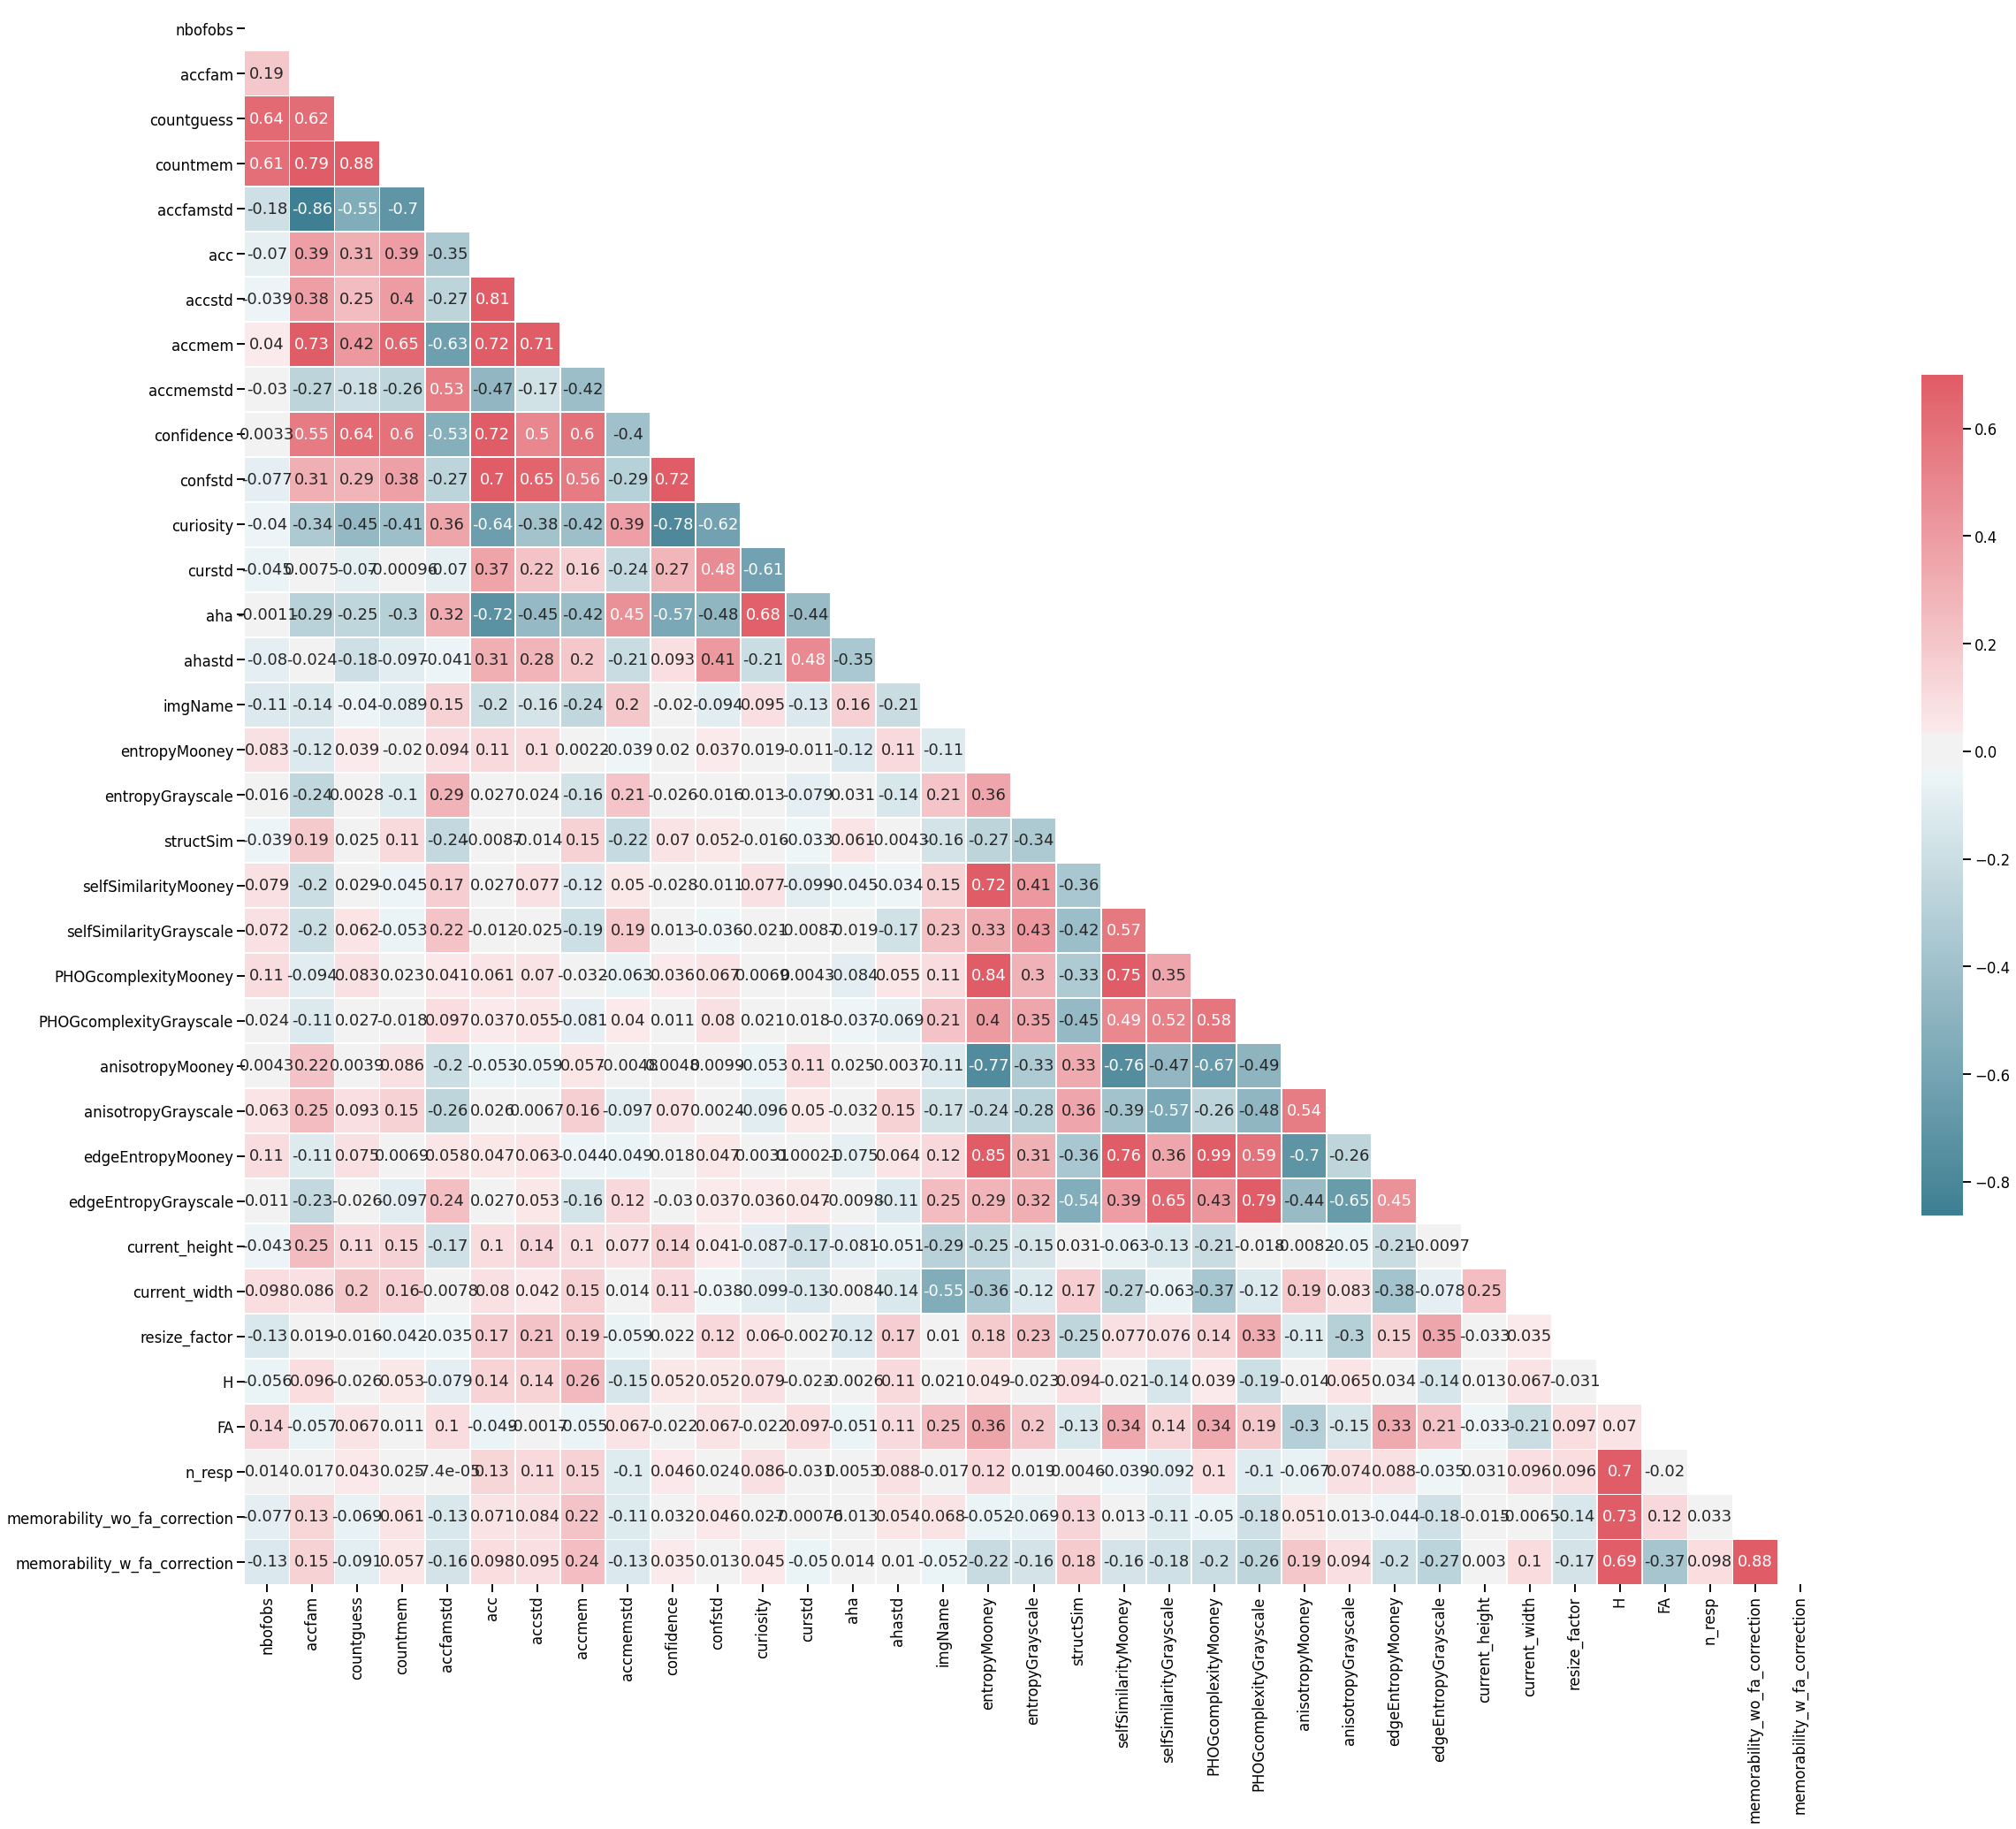

In [54]:
# Compute the correlation matrix
corr = dfim.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(40, 35))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.7, center=0,
            square=True, linewidths=.5, annot= True, cbar_kws={"shrink": .5});

pearson r = 0.181 p-value =  0.065


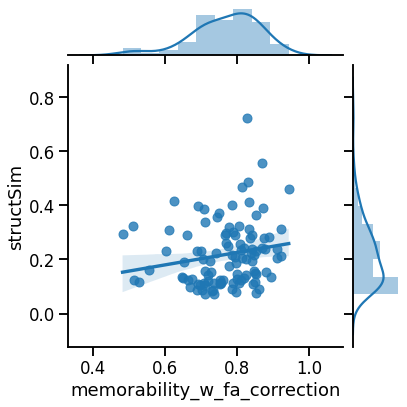

In [56]:
sns.jointplot(x="memorability_w_fa_correction", y="structSim", data=dfim, kind="reg");

r, p = stats.pearsonr(dfim.dropna().memorability_w_fa_correction, dfim.dropna().structSim)
print('pearson r =', round(r,3), 'p-value = ', round(p,3))

pearson r = -0.271 p-value =  0.005


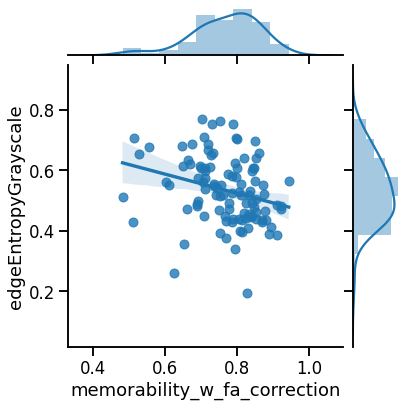

In [57]:
sns.jointplot(x="memorability_w_fa_correction", y="edgeEntropyGrayscale", data=dfim, kind="reg");

r, p = stats.pearsonr(dfim.dropna().memorability_w_fa_correction, dfim.dropna().edgeEntropyGrayscale)
print('pearson r =', round(r,3), 'p-value = ', round(p,3))

# Random forest (TODO)

Tutorial here: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

TODO: crossvalidation, multicollinearity: https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py

In [77]:
#for i, v in enumerate(dfo.columns):
#    print(i, v)

print(df.dtypes)

X =  dfo.drop(['currentStim', 'guess','old','subject', 'guessmem', 'accfam', 'accmem','madeguess', 'rtpostguess', 'rtfamiliar', 'rtguess', 'rtaha', 'rtcurcon', 'aha', 'confidence','curiosity'], axis=1)
X= dfo[['aha_z', 'confidence_z', 'acc']]
y = dfo.accmem


#for i, v in enumerate(X.columns):
#    print(i, v, X[v].isnull().sum())


Unnamed: 0       int64
currentStim     object
curiosity      float64
confidence     float64
aha            float64
                ...   
imagination      int64
numbpatt         int64
acc              int64
accmem           int64
madeguess        int64
Length: 115, dtype: object


In [26]:
X.isnull().sum()

aha_z            0
curiosity_z     80
confidence_z     0
acc              0
dtype: int64

In [14]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn import metrics

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

In [79]:
#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

In [80]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6232704402515723


In [81]:
feature_imp = pd.Series(clf.feature_importances_,index=X.columns).sort_values(ascending=False)
feature_imp

confidence_z    0.432375
aha_z           0.419546
acc             0.148079
dtype: float64

In [39]:
feature_imp[:20]

rtaha           0.174803
rtcurcon        0.172053
aha_z           0.071102
acc             0.068567
confidence_z    0.059652
curiosity_z     0.055808
aha             0.054988
confidence      0.050675
curiosity       0.044766
perccur         0.006001
AQ28            0.005915
imagination     0.005480
NCS             0.004817
fiveDCR         0.004805
socskills       0.004498
numbpatt        0.003928
stresstol       0.003840
thrillseek      0.003826
switching       0.003781
30              0.003665
dtype: float64

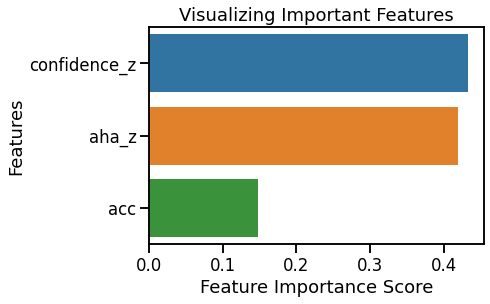

In [82]:
import matplotlib.pyplot as plt

# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features");
